Compute statistics for each story

In [334]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import re
import altair as alt
from scipy.stats import ttest_ind
import scipy.stats as stats

In [248]:
# llm-generated stories
llm_stories = ["bookstore", "color", "starlight", "threads", "time", "whispers"]
plays = ["faust", "hamlet", "pygmalion", "romeo", "school"]
exclude_stories = ["yourname"]

In [3]:
# load in data files
data_folder = "../src/data/"
data_files = os.listdir(data_folder)
data_files = [f for f in data_files if f.endswith(".json") and 'new' in f]

# remove any stories in "exclude_stories"
data_files = [f for f in data_files if not any([s in f for s in exclude_stories])]

sorted_data_files = sorted(data_files)
sorted_data_files

['alice-new-themes.json',
 'alice-new.json',
 'anne-new-themes.json',
 'anne-new.json',
 'artofwar-new-themes.json',
 'artofwar-new.json',
 'bookstore-new-themes.json',
 'bookstore-new.json',
 'candide-new-themes.json',
 'candide-new.json',
 'color-new-themes.json',
 'color-new.json',
 'donquixote-new-themes.json',
 'donquixote-new.json',
 'emma-new-themes.json',
 'emma-new.json',
 'faust-new-themes.json',
 'faust-new.json',
 'frankenstein-new-themes.json',
 'frankenstein-new.json',
 'gatsby-new-themes.json',
 'gatsby-new.json',
 'genji-new-themes.json',
 'genji-new.json',
 'greatexp-new-themes.json',
 'greatexp-new.json',
 'hamlet-new-themes.json',
 'hamlet-new.json',
 'iliad-new-themes.json',
 'iliad-new.json',
 'janeeyre-new-themes.json',
 'janeeyre-new.json',
 'littlewomen-new-themes.json',
 'littlewomen-new.json',
 'marrow-new-themes.json',
 'marrow-new.json',
 'mendips-new-themes.json',
 'mendips-new.json',
 'metamorphosis-new-themes.json',
 'metamorphosis-new.json',
 'odyssey-ne

In [249]:
# create df to store results
# this will have all data points
df = pd.DataFrame(columns=[
    "story", "themes", "llm_generated", "is_play",
    "num_lines", "num_chapters", "num_scenes", "num_characters", "num_locations", 
    "real_quote_percent",
    "lines_per_chapter", "scenes_per_chapter", "characters_per_chapter", "locations_per_chapter",
    "lines_per_scene", "characters_per_scene"
    ])

# this is the average of the above
average_df = pd.DataFrame(columns=[
    "story", "themes", "llm_generated", "is_play",
    "real_quote_percent",
    "lines_per_chapter", "scenes_per_chapter", "characters_per_chapter", "locations_per_chapter",
    "lines_per_scene", "characters_per_scene"
    ])

In [250]:
all_data = []
average_data = []

# loop through data files
for f in sorted_data_files:
    with open(data_folder + f, 'r') as file:
        data = json.load(file)

    # chapter/scene data
    chapter_data = data["chapters"]
    scene_data = data["scenes"]

    # general info
    story = f.split("-")[0]
    themes = "themes" in f
    llm_generated = story in llm_stories
    is_play = story in plays
    num_chapters = data["num_chapters"]
    num_scenes = data["num_scenes"]
    num_characters = data["num_characters"]
    num_locations = data["num_locations"]

    # chapter data
    lines_per_chapter = [chapter["num_lines"] for chapter in chapter_data]
    num_lines = sum(lines_per_chapter)
    scenes_per_chapter = [chapter["scenes"] for chapter in chapter_data]
    characters_per_chapter = [len(chapter["characters"]) for chapter in chapter_data]
    locations_per_chapter = [len(chapter["locations"]) for chapter in chapter_data]

    # scene data
    lines_per_scene = [scene["num_lines"] for scene in scene_data]
    characters_per_scene = [len(scene["characters"]) for scene in scene_data]

    # character data
    # compute number of real and fake quotes
    real_quotes = 0
    fake_quotes = 0
    for scene in scene_data:
        for character in scene["characters"]:
            if "No quote available" in character["quote"]:
                fake_quotes += 1
            else:
                real_quotes += 1

    # compute percentage of real quotes
    total_quotes = real_quotes + fake_quotes
    real_quote_percent = real_quotes / total_quotes

    # Add to the all_data list
    all_data.append({
        "story": story, 
        "themes": themes, 
        "llm_generated": llm_generated,
        "is_play": is_play,
        "num_lines": num_lines, 
        "num_chapters": num_chapters, 
        "num_scenes": num_scenes, 
        "num_characters": num_characters, 
        "num_locations": num_locations, 
        "real_quote_percent": real_quote_percent,
        "lines_per_chapter": lines_per_chapter,
        "scenes_per_chapter": scenes_per_chapter,
        "characters_per_chapter": characters_per_chapter, 
        "locations_per_chapter": locations_per_chapter, 
        "lines_per_scene": lines_per_scene, 
        "characters_per_scene": characters_per_scene
    })

    # Add to the average_data list
    average_data.append({
        "story": story, 
        "themes": themes, 
        "llm_generated": llm_generated,
        "is_play": is_play,
        "num_lines": num_lines,
        "real_quote_percent": real_quote_percent,
        "lines_per_chapter": sum(lines_per_chapter) / num_chapters,
        "scenes_per_chapter": sum(scenes_per_chapter) / num_chapters,
        "characters_per_chapter": sum(characters_per_chapter) / num_chapters, 
        "locations_per_chapter": sum(locations_per_chapter) / num_chapters, 
        "lines_per_scene": sum(lines_per_scene) / num_scenes, 
        "characters_per_scene": sum(characters_per_scene) / num_scenes,
    })

# Convert lists to DataFrames
df = pd.DataFrame(all_data)
average_df = pd.DataFrame(average_data)

In [251]:
# also categorize stories by length
min_length = int(df["num_lines"].min())
max_length = int(df["num_lines"].max())

# Categorize based on quartiles and handle outliers
def categorize_length(num_lines):
    if num_lines <= 5000:
        return "short"  # Extreme low values
    elif num_lines >= 10000:
        return "long"   # Extreme high values
    else:
        return "medium"  # Everything else in between

# Apply function to create new column
df["story_length"] = df["num_lines"].apply(categorize_length)
average_df["story_length"] = average_df["num_lines"].apply(categorize_length)

min_length, max_length

(1388, 25435)

In [252]:
# number of stories
num_stories = len(df["story"].unique())
num_stories

36

In [253]:
# print number of stories that are not LLM-generated
num_non_llm = df[df["llm_generated"] == False]["story"].unique()
len(num_non_llm), num_non_llm

(30,
 array(['alice', 'anne', 'artofwar', 'candide', 'donquixote', 'emma',
        'faust', 'frankenstein', 'gatsby', 'genji', 'greatexp', 'hamlet',
        'iliad', 'janeeyre', 'littlewomen', 'marrow', 'mendips',
        'metamorphosis', 'odyssey', 'pride', 'pygmalion', 'redchamber',
        'romeo', 'school', 'tenant', 'trial', 'ulysses', 'victoria', 'war',
        'wizard'], dtype=object))

In [254]:
df.head()

,story,themes,llm_generated,is_play,num_lines,num_chapters,num_scenes,num_characters,num_locations,real_quote_percent,lines_per_chapter,scenes_per_chapter,characters_per_chapter,locations_per_chapter,lines_per_scene,characters_per_scene,story_length
0,alice,True,False,False,2463,12,60,72,22,0.899471,"[181, 172, 156, 216, 213, 235, 232, 231, 224, ...","[6, 2, 6, 7, 2, 5, 2, 4, 7, 5, 6, 8]","[12, 7, 16, 14, 5, 7, 7, 11, 13, 10, 10, 16]","[5, 1, 4, 4, 2, 4, 2, 1, 4, 1, 1, 3]","[21, 57, 32, 16, 22, 14, 29, 75, 16, 30, 32, 1...","[3, 4, 3, 3, 3, 2, 4, 4, 3, 3, 3, 3, 4, 3, 2, ...",short
1,alice,False,False,False,2463,12,60,36,22,0.806818,"[181, 172, 156, 216, 213, 235, 232, 231, 224, ...","[6, 2, 6, 7, 2, 5, 2, 4, 7, 5, 6, 8]","[2, 2, 10, 6, 3, 7, 4, 9, 6, 3, 11, 11]","[5, 1, 4, 4, 2, 4, 2, 1, 4, 1, 1, 3]","[21, 57, 32, 16, 22, 14, 29, 75, 16, 30, 32, 1...","[2, 1, 2, 1, 1, 1, 1, 2, 3, 5, 3, 3, 2, 6, 2, ...",short
2,anne,True,False,False,8703,38,229,236,55,0.930943,"[238, 410, 199, 197, 168, 162, 106, 253, 216, ...","[7, 6, 6, 5, 1, 4, 4, 3, 4, 5, 5, 4, 4, 5, 5, ...","[17, 14, 18, 13, 4, 13, 11, 10, 11, 15, 14, 12...","[2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 2, 2, 3, ...","[28, 38, 25, 21, 66, 56, 4, 20, 30, 50, 80, 86...","[3, 3, 3, 3, 4, 3, 2, 3, 3, 3, 4, 4, 5, 3, 3, ...",medium
3,anne,False,False,False,8703,38,229,41,55,0.726837,"[238, 410, 199, 197, 168, 162, 106, 253, 216, ...","[7, 6, 6, 5, 1, 4, 4, 3, 4, 5, 5, 4, 4, 5, 5, ...","[3, 3, 3, 3, 2, 6, 3, 2, 4, 4, 5, 5, 3, 3, 6, ...","[2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 2, 2, 3, ...","[28, 38, 25, 21, 66, 56, 4, 20, 30, 50, 80, 86...","[1, 2, 3, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, ...",medium
4,artofwar,True,False,False,7571,13,136,190,11,0.930693,"[148, 149, 211, 145, 222, 250, 2660, 1675, 400...","[6, 8, 7, 2, 11, 6, 8, 10, 12, 16, 28, 3, 19]","[17, 13, 20, 8, 27, 20, 22, 23, 27, 27, 53, 11...","[3, 5, 2, 1, 3, 3, 2, 5, 5, 5, 7, 2, 6]","[4, 41, 33, 27, 33, 10, 4, 15, 43, 28, 6, 14, ...","[2, 4, 5, 3, 3, 2, 2, 2, 3, 3, 2, 3, 4, 2, 2, ...",medium


In [255]:
average_df.head()

,story,themes,llm_generated,is_play,num_lines,real_quote_percent,lines_per_chapter,scenes_per_chapter,characters_per_chapter,locations_per_chapter,lines_per_scene,characters_per_scene,story_length
0,alice,True,False,False,2463,0.899471,205.250000,5.000000,10.666667,2.666667,38.866667,3.150000,short
1,alice,False,False,False,2463,0.806818,205.250000,5.000000,6.166667,2.666667,38.866667,2.933333,short
2,anne,True,False,False,8703,0.930943,229.026316,6.026316,16.342105,3.052632,35.480349,3.288210,medium
3,anne,False,False,False,8703,0.726837,229.026316,6.026316,5.789474,3.052632,35.480349,2.733624,medium
4,artofwar,True,False,False,7571,0.930693,582.384615,10.461538,23.923077,3.769231,26.845588,2.970588,medium


In [256]:
# overall averages
# real quote percentage
real_quote_avg = average_df["real_quote_percent"].mean()

# scenes per chapter
scenes_per_chapter_avg = average_df["scenes_per_chapter"].mean()

# characters per chapter
characters_per_chapter_avg = average_df["characters_per_chapter"].mean()

# locations per chapter
locations_per_chapter_avg = average_df["locations_per_chapter"].mean()

# lines per scene
lines_per_scene_avg = average_df["lines_per_scene"].mean()

# characters per scene
characters_per_scene_avg = average_df["characters_per_scene"].mean()

print("Real quote percentage:", real_quote_avg)
print("Scenes per chapter:", scenes_per_chapter_avg)
print("Characters per chapter:", characters_per_chapter_avg)
print("Locations per chapter:", locations_per_chapter_avg)
print("Lines per scene:", lines_per_scene_avg)
print("Characters per scene:", characters_per_scene_avg)

Real quote percentage: 0.8675419200283474
Scenes per chapter: 6.104955832494736
Characters per chapter: 11.988263087832578
Locations per chapter: 3.597715200249837
Lines per scene: 59.167149141712194
Characters per scene: 3.1584732473356274


In [268]:
# get average for average_df
llm_avg = average_df.groupby(["llm_generated"]).mean(numeric_only=True)
theme_avg = average_df.groupby(["themes"]).mean(numeric_only=True)
length_avg = average_df.groupby(["story_length"]).mean(numeric_only=True)
play_avg = average_df.groupby("is_play").mean(numeric_only=True)

# sd for average_df
llm_sd = average_df.groupby(["llm_generated"]).std(numeric_only=True)
theme_sd = average_df.groupby(["themes"]).std(numeric_only=True)
length_sd = average_df.groupby(["story_length"]).std(numeric_only=True)
play_sd = average_df.groupby("is_play").std(numeric_only=True)

# remove num_lines and is_play from llm_avg and llm_sd
llm_avg = llm_avg.drop(columns=["num_lines", "is_play"])
llm_sd = llm_sd.drop(columns=["num_lines", "is_play"])
theme_avg = theme_avg.drop(columns=["num_lines", "is_play"])
theme_sd = theme_sd.drop(columns=["num_lines", "is_play"])
length_avg = length_avg.drop(columns=["num_lines", "is_play"])
length_sd = length_sd.drop(columns=["num_lines", "is_play"])
play_avg = play_avg.drop(columns=["num_lines"])
play_sd = play_sd.drop(columns=["num_lines"])

# filter columns for theme_avg and theme_sd
theme_avg = theme_avg[["llm_generated", "real_quote_percent", "characters_per_chapter", "characters_per_scene"]]
theme_sd = theme_sd[["llm_generated", "real_quote_percent", "characters_per_chapter", "characters_per_scene"]]

# drop themes and llm_generated from length_avg and length_sd
length_avg = length_avg.drop(columns=["themes", "llm_generated"])
length_sd = length_sd.drop(columns=["themes", "llm_generated"])

# drop themes and llm_generated from play_avg and play_sd
play_avg = play_avg.drop(columns=["themes", "llm_generated"])
play_sd = play_sd.drop(columns=["themes", "llm_generated"])

In [260]:
llm_avg

,themes,real_quote_percent,lines_per_chapter,scenes_per_chapter,characters_per_chapter,locations_per_chapter,lines_per_scene,characters_per_scene
llm_generated,,,,,,,,
False,0.5,0.860966,490.859922,6.542614,12.956749,3.789480,64.336528,3.207746
True,0.5,0.900422,132.361111,3.916667,7.145833,2.638889,33.320255,2.912109


In [261]:
llm_sd

,themes,real_quote_percent,lines_per_chapter,scenes_per_chapter,characters_per_chapter,locations_per_chapter,lines_per_scene,characters_per_scene
llm_generated,,,,,,,,
False,0.504219,0.111168,301.687540,2.310272,6.481415,1.738785,35.652568,0.360102
True,0.522233,0.058624,10.146237,0.770347,3.483389,0.690240,5.129329,0.553504


In [262]:
theme_avg

,llm_generated,real_quote_percent,characters_per_chapter,characters_per_scene
themes,,,,
False,0.166667,0.794340,8.342977,2.970113
True,0.166667,0.940744,15.633550,3.346833


In [263]:
theme_sd

,llm_generated,real_quote_percent,characters_per_chapter,characters_per_scene
themes,,,,
False,0.377964,0.103053,4.078018,0.472193
True,0.377964,0.026728,6.349026,0.209521


In [264]:
length_avg

,real_quote_percent,lines_per_chapter,scenes_per_chapter,characters_per_chapter,locations_per_chapter,lines_per_scene,characters_per_scene
story_length,,,,,,,
long,0.848715,528.618536,7.021196,14.557662,4.650171,56.276590,3.167322
medium,0.859094,575.919958,7.434754,14.883106,3.984145,72.140957,3.171075
short,0.883940,276.704872,4.675334,8.552771,2.740038,51.873596,3.144832


In [265]:
length_sd

,real_quote_percent,lines_per_chapter,scenes_per_chapter,characters_per_chapter,locations_per_chapter,lines_per_scene,characters_per_scene
story_length,,,,,,,
long,0.115536,375.393805,2.274605,6.787014,2.266761,21.124827,0.350273
medium,0.114020,282.465821,2.533647,7.296423,1.527166,46.572329,0.404026
short,0.092636,195.900562,1.247048,3.444042,0.666459,29.079437,0.453310


In [266]:
play_avg

,real_quote_percent,lines_per_chapter,scenes_per_chapter,characters_per_chapter,locations_per_chapter,lines_per_scene,characters_per_scene
is_play,,,,,,,
False,0.851804,384.065055,6.301761,12.20511,3.728837,48.687250,3.089923
True,0.965117,722.789524,4.884762,10.64381,2.784762,124.142526,3.583483


In [269]:
play_sd

,real_quote_percent,lines_per_chapter,scenes_per_chapter,characters_per_chapter,locations_per_chapter,lines_per_scene,characters_per_scene
is_play,,,,,,,
False,0.104576,293.330943,2.462746,6.832530,1.732028,20.871198,0.385582
True,0.023218,215.931633,0.589301,2.999535,0.829212,32.154768,0.284413


In [16]:
def compare_strings(s1: str, s2: str) -> bool:
    """
    Compare if two strings are equal ignoring case and punctuation.

    Args:
        s1 (str): The first string to compare.
        s2 (str): The second string to compare.

    Returns:
        bool: True if the strings are equal ignoring case and punctuation, False otherwise.
    """
    # Remove punctuation and convert to lowercase
    def preprocess(s: str) -> str:
        # Normalize case and remove punctuation except periods for 'CHAPTER X.'
        s = ''.join(char.lower() if char != '.' else '' for char in s if char not in string.punctuation or char == '.')
        # Extract "chapter <number>" using regex
        match = re.match(r'\bchapter\s+\w+', s)
        return match.group(0) if match else s.strip()

    return preprocess(s1) == preprocess(s2)

### ground truth check

In [17]:
# read in original story data from data/scenes_per_chapter.csv
original_data = pd.read_csv("data/scenes_per_chapter.csv")

og_stories = original_data["story"].unique()

# remove any stories in "exclude_stories"
og_stories = [s for s in og_stories if s not in exclude_stories]

og_stories

['gatsby',
 'romeo',
 'alice',
 'mendips',
 'victoria',
 'color',
 'whispers',
 'bookstore',
 'starlight',
 'time',
 'threads']

In [18]:
# get diffs between ground truth and generated data
og_diffs = []
for story in og_stories:
    theme_data = df[(df["story"] == story) & (df["themes"] == True)]
    non_theme_data = df[(df["story"] == story) & (df["themes"] == False)]

    story_chapters = original_data[original_data["story"] == story]["chapter"].values

    with open(data_folder + story + "-new.json", 'r') as file:
        char_data = json.load(file)

    with open(data_folder + story + "-new-themes.json", 'r') as file:
        themes_data = json.load(file)

    non_theme_chapters = char_data["chapters"]
    theme_chapters = themes_data["chapters"]

    non_theme_names = [chapter["chapter"] for chapter in non_theme_chapters]
    theme_names = [chapter["chapter"] for chapter in theme_chapters]

    # collect chapters in both versions
    non_theme_matches = []
    theme_matches = []
    for non_theme_chapter in non_theme_names:
        if any(compare_strings(non_theme_chapter, story_chapter) for story_chapter in story_chapters):
            non_theme_matches.append(non_theme_chapter)
    for theme_chapter in theme_names:
        if any(compare_strings(theme_chapter, story_chapter) for story_chapter in story_chapters):
            theme_matches.append(theme_chapter)

    # print(f"Story: {story}")
    # print(f"Non-theme chapters: {non_theme_matches}")
    # print(f"Theme chapters: {theme_matches}")

    scenes_per_chapter_diff_nontheme = []
    scenes_per_chapter_diff_theme = []
    for chapter in non_theme_matches:
        og_chapter_name = next((story_chapter for story_chapter in story_chapters if compare_strings(chapter, story_chapter)), None)
        og_chapter = original_data[(original_data["story"] == story) & (original_data["chapter"] == og_chapter_name)]
        gen_chapter = char_data["chapters"][non_theme_names.index(chapter)]
        scenes_per_chapter_diff_nontheme.append((og_chapter["scenes"].values[0] - gen_chapter["scenes"]))
    for chapter in theme_matches:
        og_chapter_name = next((story_chapter for story_chapter in story_chapters if compare_strings(chapter, story_chapter)), None)
        og_chapter = original_data[(original_data["story"] == story) & (original_data["chapter"] == og_chapter_name)]
        gen_chapter = themes_data["chapters"][theme_names.index(chapter)]
        scenes_per_chapter_diff_theme.append((og_chapter["scenes"].values[0] - gen_chapter["scenes"]))
    
    avg_scene_per_chapter_diff_nontheme = np.mean(scenes_per_chapter_diff_nontheme)
    avg_scene_per_chapter_diff_theme = np.mean(scenes_per_chapter_diff_theme)

    # append one entry for non-theme and one for theme
    og_diffs.append({
        "story": story,
        "themes": False,
        "llm_generated": non_theme_data["llm_generated"].values[0],
        "scene_per_chapter_diff": scenes_per_chapter_diff_nontheme,
        "avg_scene_per_chapter_diff": avg_scene_per_chapter_diff_nontheme
    })

    og_diffs.append({
        "story": story,
        "themes": True,
        "llm_generated": theme_data["llm_generated"].values[0],
        "scene_per_chapter_diff": scenes_per_chapter_diff_theme,
        "avg_scene_per_chapter_diff": avg_scene_per_chapter_diff_theme
    })

# convert to DataFrame
print(len(og_diffs))
og_diffs_df = pd.DataFrame(og_diffs)
og_diffs_df.head()

22


/Users/catherineyeh/.local/share/virtualenvs/story-viz-mNgXibik/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/catherineyeh/.local/share/virtualenvs/story-viz-mNgXibik/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,story,themes,llm_generated,scene_per_chapter_diff,avg_scene_per_chapter_diff
0,gatsby,False,False,"[-1, -3, -9, -1, -8, -2, -3, 1, 0]",-2.888889
1,gatsby,True,False,"[-1, -3, -9, -1, -8, -2, -3, 1, 0]",-2.888889
2,romeo,False,False,"[2, 0, 0, 0, -2]",0.000000
3,romeo,True,False,"[2, 0, 0, 0, -2]",0.000000
4,alice,False,False,"[-4, -1, -5, -6, 0, -4, -1, -3, -6, -4, -5, -6]",-3.750000


In [19]:
og_diff_avg_themes = og_diffs_df.groupby(["themes"]).mean(numeric_only=True)
og_diff_sd_themes = og_diffs_df.groupby(["themes"]).std(numeric_only=True)

og_diff_avg_themes, og_diff_sd_themes

(        llm_generated  avg_scene_per_chapter_diff
 themes                                           
 False        0.545455                   -1.293301
 True         0.545455                   -1.293301,
         llm_generated  avg_scene_per_chapter_diff
 themes                                           
 False        0.522233                    2.264679
 True         0.522233                    2.264679)

In [20]:
og_diff_avg_llm = og_diffs_df.groupby(["llm_generated"]).mean(numeric_only=True)
og_diff_sd_llm = og_diffs_df.groupby(["llm_generated"]).std(numeric_only=True)

og_diff_avg_llm, og_diff_sd_llm

(               themes  avg_scene_per_chapter_diff
 llm_generated                                    
 False             0.5               -3.233252e+00
 True              0.5                2.312965e-18,
                  themes  avg_scene_per_chapter_diff
 llm_generated                                      
 False          0.527046                    2.402881
 True           0.522233                    0.395684)

### themes vs characters

In [35]:
# get diffs between theme and non-theme version of each story
diffs = []
for story in df["story"].unique():
    # print(story)
    theme_data = df[(df["story"] == story) & (df["themes"] == True)]
    non_theme_data = df[(df["story"] == story) & (df["themes"] == False)]

    # diff in number of chapters, scenes and locations per story
    # diff_num_chapters = non_theme_data["num_chapters"].values[0] - theme_data["num_chapters"].values[0]
    # diff_num_scenes = non_theme_data["num_scenes"].values[0] - theme_data["num_scenes"].values[0]
    # diff_num_locations = non_theme_data["num_locations"].values[0] - theme_data["num_locations"].values[0]

    with open(data_folder + story + "-new.json", 'r') as file:
        char_data = json.load(file)

    with open(data_folder + story + "-new-themes.json", 'r') as file:
        themes_data = json.load(file)

    # non_theme_chapters = char_data["chapters"]
    # theme_chapters = themes_data["chapters"]

    # non_theme_names = [chapter["chapter"] for chapter in non_theme_chapters]
    # theme_names = [chapter["chapter"] for chapter in theme_chapters]

    # collect chapters in both versions
    # common_chapters = []
    # for non_theme_chapter in non_theme_names:
    #     if any(compare_strings(non_theme_chapter, theme_chapter) for theme_chapter in theme_names):
    #         common_chapters.append(non_theme_chapter)

    # diff in number of scenes and locations per chapter
    # scenes_per_chapter_diff = []
    # locations_per_chapter_diff = []
    # for chapter in common_chapters:
    #     non_theme_chapter = next((c for c in non_theme_chapters if compare_strings(c["chapter"], chapter)), None)
    #     theme_chapter = next((c for c in theme_chapters if compare_strings(c["chapter"], chapter)), None)
    #     scenes_per_chapter_diff.append(non_theme_chapter["scenes"] - theme_chapter["scenes"])
    #     locations_per_chapter_diff.append(len(non_theme_chapter["locations"]) - len(theme_chapter["locations"]))
    # avg_scene_per_chapter_diff = np.mean(scenes_per_chapter_diff)
    # avg_location_per_chapter_diff = np.mean(locations_per_chapter_diff)

    # diff in number of real/fake quotes
    real_quotes_diff = non_theme_data["real_quote_percent"].values[0] - theme_data["real_quote_percent"].values[0]

    # diff in number of lines per scene
    # theme_data_avg = average_df[(average_df["story"] == story) & (average_df["themes"] == True)]
    # non_theme_data_avg = average_df[(average_df["story"] == story) & (average_df["themes"] == False)]
    # scene_lines_diff = non_theme_data_avg["lines_per_scene"].values[0] - theme_data_avg["lines_per_scene"].values[0]


    # append to diffs
    diffs.append({
        "story": story,
        "llm_generated": theme_data["llm_generated"].values[0],
        # "diff_num_chapters": diff_num_chapters,
        # "diff_num_scenes": diff_num_scenes,
        # "diff_num_locations": diff_num_locations,
        # "scene_per_chapter_diff": scenes_per_chapter_diff,
        # "avg_scene_per_chapter_diff": avg_scene_per_chapter_diff,
        # "locations_per_chapter_diff": locations_per_chapter_diff,
        # "avg_location_per_chapter_diff": avg_location_per_chapter_diff,
        "real_quote_percent_diff": real_quotes_diff,
        # "scene_lines_diff": scene_lines_diff
    })

# convert to DataFrame
diff_df = pd.DataFrame(diffs)
diff_df.head()

,story,llm_generated,real_quote_percent_diff
0,alice,False,-0.092653
1,anne,False,-0.204106
2,artofwar,False,-0.073143
3,bookstore,True,-0.039533
4,candide,False,-0.313835


In [36]:
# get average for diff_df based on llm_generated
llm_diff_avg = diff_df.groupby(["llm_generated"]).mean(numeric_only=True)
llm_diff_avg

,real_quote_percent_diff
llm_generated,
False,-0.162836
True,-0.064242


In [37]:
# normalize the data
# min_diff_num_scenes = diff_df["diff_num_scenes"].min()
# max_diff_num_scenes = diff_df["diff_num_scenes"].max()
# # make min and max the same number but opposite sign
# new_max_diff_num_scenes = max(abs(min_diff_num_scenes), abs(max_diff_num_scenes))
# new_min_diff_num_scenes = -new_max_diff_num_scenes
# llm_diff_avg["diff_num_scenes"] = -1 + 2 * ((llm_diff_avg["diff_num_scenes"] - new_min_diff_num_scenes) / (new_max_diff_num_scenes - new_min_diff_num_scenes))
# print(new_min_diff_num_scenes, new_max_diff_num_scenes)

# min_diff_num_locations = diff_df["diff_num_locations"].min()
# max_diff_num_locations = diff_df["diff_num_locations"].max()
# new_max_diff_num_locations = max(abs(min_diff_num_locations), abs(max_diff_num_locations))
# new_min_diff_num_locations = -new_max_diff_num_locations
# llm_diff_avg["diff_num_locations"] = -1 + 2 * ((llm_diff_avg["diff_num_locations"] - new_min_diff_num_locations) / (new_max_diff_num_locations - new_min_diff_num_locations))
# print(new_min_diff_num_locations, new_max_diff_num_locations)

# min_avg_scene_per_chapter_diff = diff_df["avg_scene_per_chapter_diff"].min()
# max_avg_scene_per_chapter_diff = diff_df["avg_scene_per_chapter_diff"].max()
# new_max_avg_scene_per_chapter_diff = max(abs(min_avg_scene_per_chapter_diff), abs(max_avg_scene_per_chapter_diff))
# new_min_avg_scene_per_chapter_diff = -new_max_avg_scene_per_chapter_diff
# llm_diff_avg["avg_scene_per_chapter_diff"] = -1 + 2 * ((llm_diff_avg["avg_scene_per_chapter_diff"] - new_min_avg_scene_per_chapter_diff) / (new_max_avg_scene_per_chapter_diff - new_min_avg_scene_per_chapter_diff))
# print(new_min_avg_scene_per_chapter_diff, new_max_avg_scene_per_chapter_diff)

# min_avg_location_per_chapter_diff = diff_df["avg_location_per_chapter_diff"].min()
# max_avg_location_per_chapter_diff = diff_df["avg_location_per_chapter_diff"].max()
# new_max_avg_location_per_chapter_diff = max(abs(min_avg_location_per_chapter_diff), abs(max_avg_location_per_chapter_diff))
# new_min_avg_location_per_chapter_diff = -new_max_avg_location_per_chapter_diff
# llm_diff_avg["avg_location_per_chapter_diff"] = -1 + 2 * ((llm_diff_avg["avg_location_per_chapter_diff"] - new_min_avg_location_per_chapter_diff) / (new_max_avg_location_per_chapter_diff - new_min_avg_location_per_chapter_diff))
# print(new_min_avg_location_per_chapter_diff, new_max_avg_location_per_chapter_diff)

# min_scene_lines_diff = diff_df["scene_lines_diff"].min()
# max_scene_lines_diff = diff_df["scene_lines_diff"].max()
# new_max_scene_lines_diff = max(abs(min_scene_lines_diff), abs(max_scene_lines_diff))
# new_min_scene_lines_diff = -new_max_scene_lines_diff
# llm_diff_avg["scene_lines_diff"] = -1 + 2 * ((llm_diff_avg["scene_lines_diff"] - new_min_scene_lines_diff) / (new_max_scene_lines_diff - new_min_scene_lines_diff))
# print(new_min_scene_lines_diff, new_max_scene_lines_diff)

# llm_diff_avg

In [38]:
# sd for diff_df based on llm_generated
llm_diff_sd = diff_df.groupby(["llm_generated"]).std(numeric_only=True)
llm_diff_sd

,real_quote_percent_diff
llm_generated,
False,0.084559
True,0.055832


In [39]:
# # normalize the data
# min_diff_num_chapters = diff_df["diff_num_chapters"].min()
# max_diff_num_chapters = diff_df["diff_num_chapters"].max()
# new_max_diff_num_chapters = max(abs(min_diff_num_chapters), abs(max_diff_num_chapters))
# new_min_diff_num_chapters = -new_max_diff_num_chapters
# llm_diff_sd['diff_num_chapters'] = -1 + 2 * ((llm_diff_sd['diff_num_chapters'] - new_min_diff_num_chapters) / (new_max_diff_num_chapters - new_min_diff_num_chapters))
# print(new_min_diff_num_chapters, new_max_diff_num_chapters)

# llm_diff_sd['diff_num_scenes'] = -1 + 2 * ((llm_diff_sd['diff_num_scenes'] - new_min_diff_num_scenes) / (new_max_diff_num_scenes - new_min_diff_num_scenes))
# print(new_min_diff_num_scenes, new_max_diff_num_scenes)

# llm_diff_sd['diff_num_locations'] = -1 + 2 * ((llm_diff_sd['diff_num_locations'] - new_min_diff_num_locations) / (new_max_diff_num_locations - new_min_diff_num_locations))
# print(new_min_diff_num_locations, new_max_diff_num_locations)

# llm_diff_sd['avg_scene_per_chapter_diff'] = -1 + 2 * ((llm_diff_sd['avg_scene_per_chapter_diff'] - new_min_avg_scene_per_chapter_diff) / (new_max_avg_scene_per_chapter_diff - new_min_avg_scene_per_chapter_diff))
# print(new_min_avg_scene_per_chapter_diff, new_max_avg_scene_per_chapter_diff)

# llm_diff_sd['avg_location_per_chapter_diff'] = -1 + 2 * ((llm_diff_sd['avg_location_per_chapter_diff'] - new_min_avg_location_per_chapter_diff) / (new_max_avg_location_per_chapter_diff - new_min_avg_location_per_chapter_diff))
# print(new_min_avg_location_per_chapter_diff, new_max_avg_location_per_chapter_diff)

# llm_diff_sd['scene_lines_diff'] = -1 + 2 * ((llm_diff_sd['scene_lines_diff'] - new_min_scene_lines_diff) / (new_max_scene_lines_diff - new_min_scene_lines_diff))
# print(new_min_scene_lines_diff, new_max_scene_lines_diff)

# llm_diff_sd

### plots

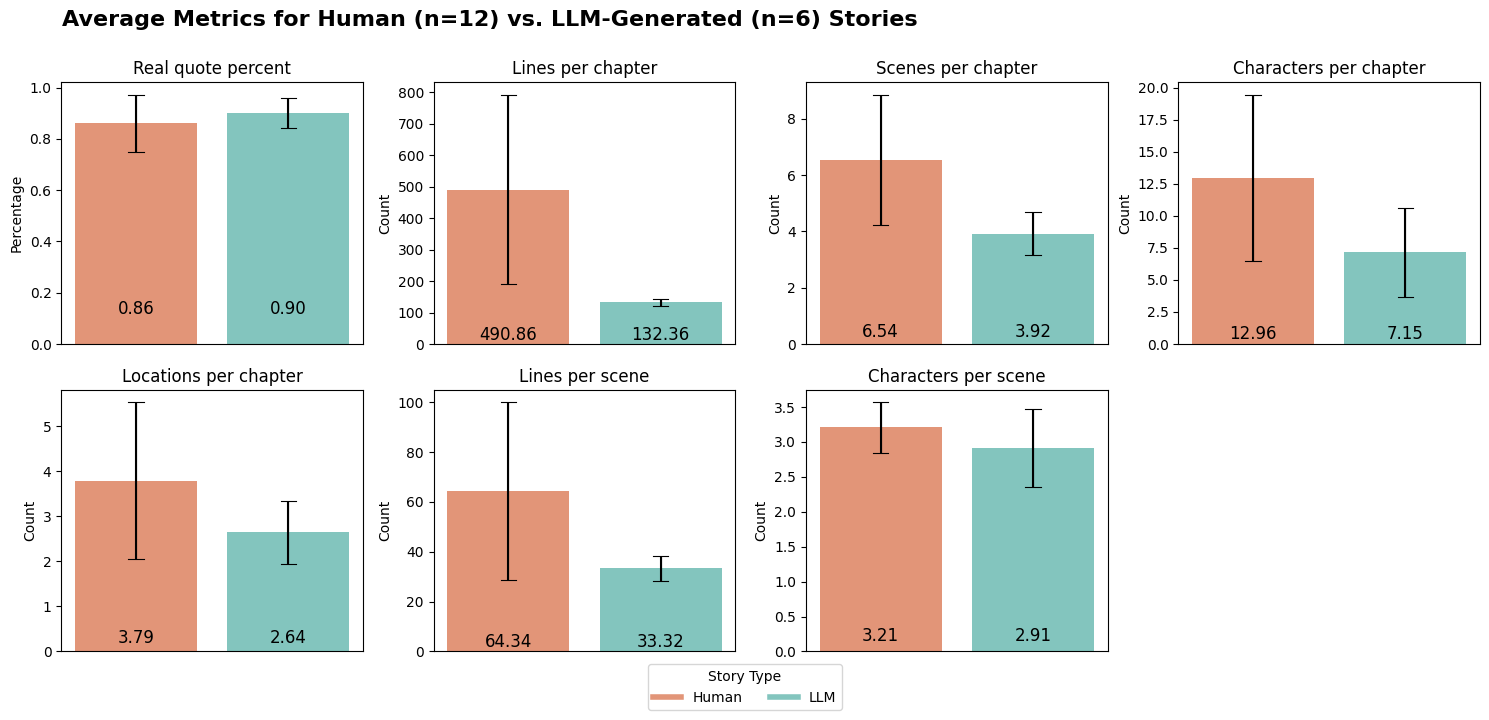

In [270]:
# Plot with adjusted label size and position slightly above y=0
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7), sharex=False, sharey=False)
axes = axes.flatten()

colors = ['#e29578', '#83c5be']

# Transpose for easier plotting
# remove 'theme' row
avg_transposed = llm_avg.transpose()
avg_transposed = avg_transposed.drop('themes')
std_transposed = llm_sd.transpose()
std_transposed = std_transposed.drop('themes')

for i, (metric, values) in enumerate(avg_transposed.iterrows()):
    ax = axes[i]
    std_values = std_transposed.loc[metric]
    
    # Plot bars with error bars
    bars = ax.bar(values.index, values.values, color=colors, yerr=std_values.values, capsize=0)
    
    # Adjusted error bar styling: thinner and gray
    for bar, std in zip(bars, std_values.values):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        # Thinner horizontal lines for error bars
        ax.plot([x - 0.05, x + 0.05], [y + std, y + std], color='black', lw=0.8)  # Top horizontal line
        ax.plot([x - 0.05, x + 0.05], [y - std, y - std], color='black', lw=0.8)  # Bottom horizontal line
        # Thinner vertical line for error bars
        ax.vlines(x, y - std, y + std, color='black', lw=0.8)  # Vertical error line (ensure gray is set explicitly)

    # Add y=0 line (dashed gray)
    ax.axhline(0, color='gray', lw=0.5, ls='--')

    ax.set_title(metric.replace('_', ' ').capitalize())
    ax.set_ylabel("Count" if metric != "real_quote_percent" else "Percentage")
    ax.set_xticks([])  # Remove x-axis labels
    ax.set_xlabel("")  # Remove x-axis title
    
    # Add labels slightly above y=0
    for bar in bars:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            0.1,  # Slightly above y=0
            f'{bar.get_height():.2f}',
            ha='center',
            va='bottom',
            fontsize=12  # Slightly larger font size
        )

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)


# add main title
fig.suptitle("Average Metrics for Human (n=12) vs. LLM-Generated (n=6) Stories", fontsize=16, fontweight='bold', x=0.33, y=0.95)

# Add one overall legend with correct color order
fig.legend(labels=['Human', 'LLM'], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.06), title="Story Type", handles=[
    plt.Line2D([0], [0], color=colors[0], lw=4),
    plt.Line2D([0], [0], color=colors[1], lw=4),
])
fig.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

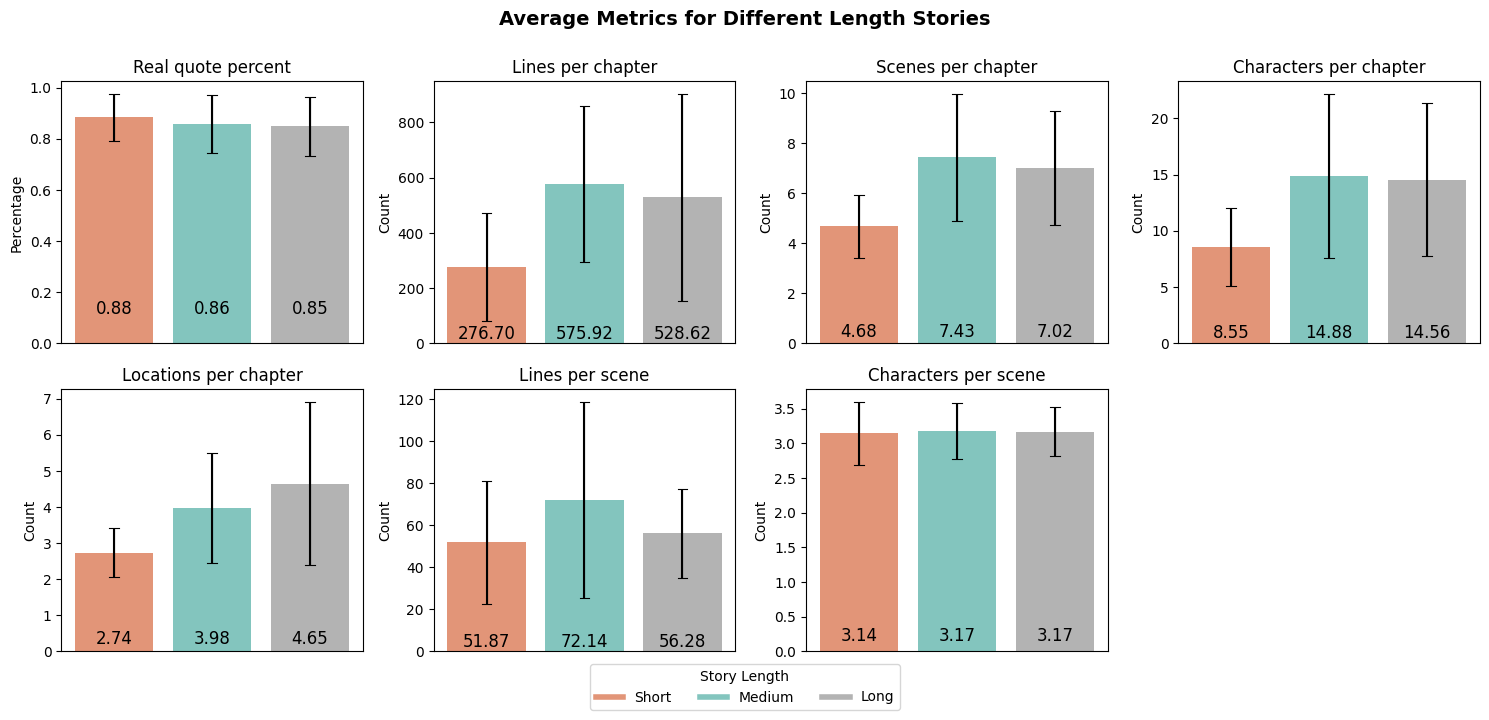

In [ ]:
# Plot with adjusted label size and position slightly above y=0
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7), sharex=False, sharey=False)
axes = axes.flatten()

# plot for length
colors = ['#e29578', '#83c5be', '#b3b3b3']

# Transpose for easier plotting
avg_transposed = length_avg.transpose()
std_transposed = length_sd.transpose()

# switch order of columns to short, medium, long
avg_transposed = avg_transposed[['short', 'medium', 'long']]
std_transposed = std_transposed[['short', 'medium', 'long']]


for i, (metric, values) in enumerate(avg_transposed.iterrows()):
    ax = axes[i]
    std_values = std_transposed.loc[metric]

    # Plot bars with error bars
    bars = ax.bar(values.index, values.values, color=colors, yerr=std_values.values, capsize=0)

    # Adjusted error bar styling: thinner and gray
    # Adjusted error bar styling: thinner and gray
    for bar, std in zip(bars, std_values.values):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        # Thinner horizontal lines for error bars
        ax.plot([x - 0.05, x + 0.05], [y + std, y + std], color='black', lw=0.8)  # Top horizontal line
        ax.plot([x - 0.05, x + 0.05], [y - std, y - std], color='black', lw=0.8)  # Bottom horizontal line
        # Thinner vertical line for error bars
        ax.vlines(x, y - std, y + std, color='black', lw=0.8)  # Vertical error line (ensure gray is set explicitly)

    # Add y=0 line (dashed gray)
    ax.axhline(0, color='gray', lw=0.5, ls='--')

    ax.set_title(metric.replace('_', ' ').capitalize())
    ax.set_ylabel("Count" if metric != "real_quote_percent" else "Percentage")
    ax.set_xticks([])  # Remove x-axis labels
    ax.set_xlabel("")  # Remove x-axis title
    
    # Add labels slightly above y=0
    for bar in bars:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            0.1,  # Slightly above y=0
            f'{bar.get_height():.2f}',
            ha='center',
            va='bottom',
            fontsize=12  # Slightly larger font size
        )

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)


# add main title
fig.suptitle("Average Metrics for Different Length Stories", fontsize=14, fontweight='bold', x=0.5, y=0.95)

# Add one overall legend with correct color order
fig.legend(labels=['Short', 'Medium', 'Long'], loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.06), title="Story Length", handles=[
    plt.Line2D([0], [0], color=colors[0], lw=4),
    plt.Line2D([0], [0], color=colors[1], lw=4),
    plt.Line2D([0], [0], color=colors[2], lw=4),
])
fig.tight_layout(rect=[0, 0, 1, 0.95])


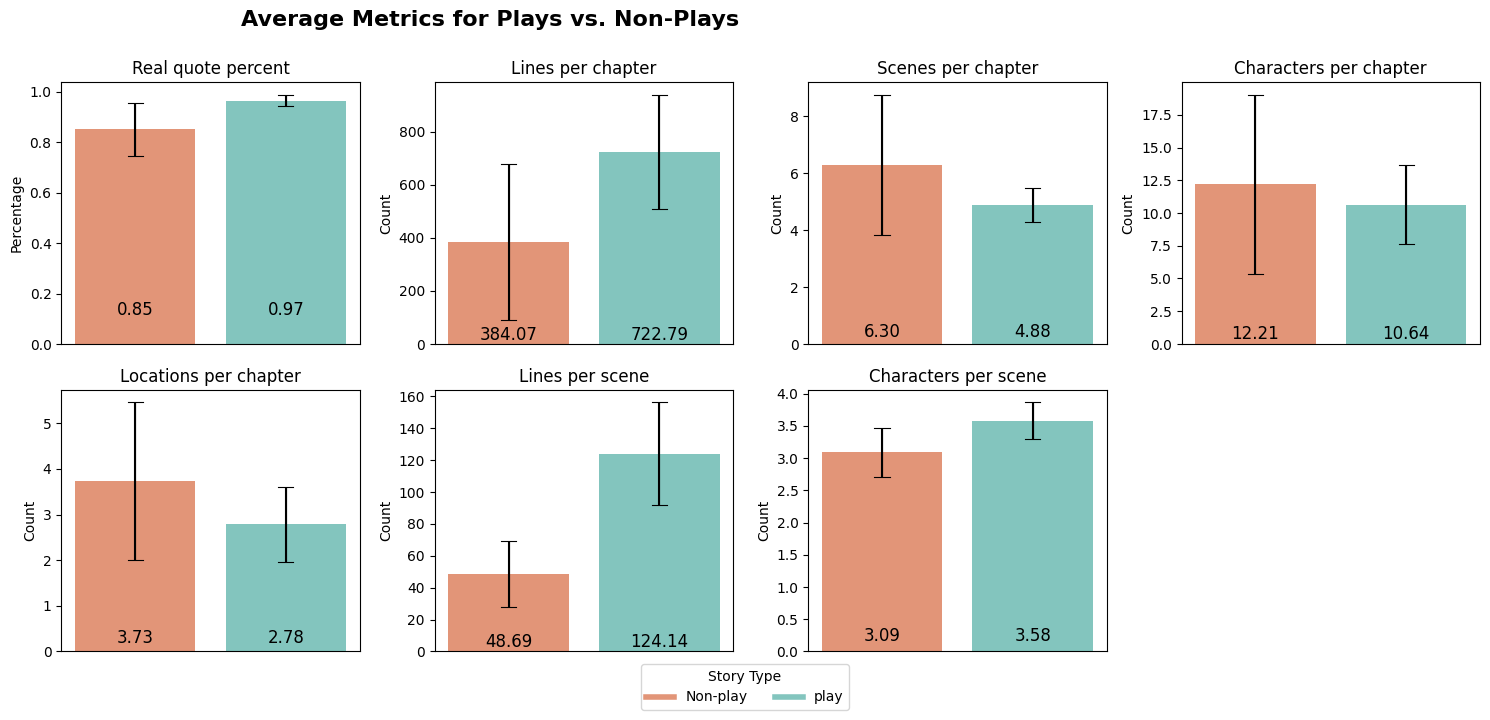

In [246]:
# Plot with adjusted label size and position slightly above y=0
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7), sharex=False, sharey=False)
axes = axes.flatten()

colors = ['#e29578', '#83c5be']

# Transpose for easier plotting
# remove 'theme' row
avg_transposed = play_avg.transpose()
std_transposed = play_sd.transpose()

for i, (metric, values) in enumerate(avg_transposed.iterrows()):
    ax = axes[i]
    std_values = std_transposed.loc[metric]
    
    # Plot bars with error bars
    bars = ax.bar(values.index, values.values, color=colors, yerr=std_values.values, capsize=0)
    
    # Adjusted error bar styling: thinner and gray
    for bar, std in zip(bars, std_values.values):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        # Thinner horizontal lines for error bars
        ax.plot([x - 0.05, x + 0.05], [y + std, y + std], color='black', lw=0.8)  # Top horizontal line
        ax.plot([x - 0.05, x + 0.05], [y - std, y - std], color='black', lw=0.8)  # Bottom horizontal line
        # Thinner vertical line for error bars
        ax.vlines(x, y - std, y + std, color='black', lw=0.8)  # Vertical error line (ensure gray is set explicitly)

    # Add y=0 line (dashed gray)
    ax.axhline(0, color='gray', lw=0.5, ls='--')

    ax.set_title(metric.replace('_', ' ').capitalize())
    ax.set_ylabel("Count" if metric != "real_quote_percent" else "Percentage")
    ax.set_xticks([])  # Remove x-axis labels
    ax.set_xlabel("")  # Remove x-axis title
    
    # Add labels slightly above y=0
    for bar in bars:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            0.1,  # Slightly above y=0
            f'{bar.get_height():.2f}',
            ha='center',
            va='bottom',
            fontsize=12  # Slightly larger font size
        )

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)


# add main title
fig.suptitle("Average Metrics for Plays vs. Non-Plays", fontsize=16, fontweight='bold', x=0.33, y=0.95)

# Add one overall legend with correct color order
fig.legend(labels=['Non-play', 'play'], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.06), title="Story Type", handles=[
    plt.Line2D([0], [0], color=colors[0], lw=4),
    plt.Line2D([0], [0], color=colors[1], lw=4),
])
fig.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

#### altair charts

In [485]:
play_quotes = df[df["is_play"] == True]["real_quote_percent"]
non_play_quotes = df[df["is_play"] == False]["real_quote_percent"]

# compute mean and standard error of the mean
play_mean, non_play_mean = play_quotes.mean(), non_play_quotes.mean()
play_sem, non_play_sem = stats.sem(play_quotes), stats.sem(non_play_quotes)

# Compute 95% CI directly using stats.t.interval
ci1 = stats.t.interval(0.95, df=len(play_quotes)-1, loc=play_mean, scale=play_sem)
ci2 = stats.t.interval(0.95, df=len(non_play_quotes)-1, loc=non_play_mean, scale=non_play_sem)

print(f"95% CI for Group 1: {ci1}")
print("Mean for Group 1:", play_mean)
print(f"95% CI for Group 2: {ci2}")
print("Mean for Group 2:", non_play_mean)

# T-test
t_stat, p_val = stats.ttest_ind(play_quotes, non_play_quotes, equal_var=False)
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_val}")

# Welch's df
n1, n2 = len(play_quotes), len(non_play_quotes)
s1, s2 = np.std(play_quotes, ddof=1), np.std(non_play_quotes, ddof=1)
num = (s1**2 / n1 + s2**2 / n2)**2
denom = (s1**2 / n1)**2 / (n1 - 1) + (s2**2 / n2)**2 / (n2 - 1)
welch_df = num / denom
print(f"Welch's df: {welch_df}")

print(len(play_quotes), len(non_play_quotes))

95% CI for Group 1: (np.float64(0.948507668118009), np.float64(0.9817259300262778))
Mean for Group 1: 0.9651167990721434
95% CI for Group 2: (np.float64(0.825246781084665), np.float64(0.8783612915385471))
Mean for Group 2: 0.8518040363116061
t-statistic: 7.46682356752526
p-value: 2.8866884042348333e-10
Welch's df: 63.67368646033253
10 62


In [486]:
# plot bar chart with altair of means for plays and non-plays (use 95% CI for error bars)

# create DataFrame for altair
data = pd.DataFrame({
    "type": ["Play", "Non-play"],
    "mean": [play_mean, non_play_mean],
    "ci_low": [ci1[0], ci2[0]],
    "ci_high": [ci1[1], ci2[1]]
})

# create altair chart
bars = alt.Chart(data).mark_bar(width=40, opacity=0.5).encode(
    x=alt.X('type', title=None, axis=alt.Axis(labelAngle=0)),
    y=alt.Y('mean', axis=alt.Axis(grid=False)),
    color=alt.Color('type:N', scale=alt.Scale(domain=['Play', 'Non-play'], range=['#6598DB', '#888888']), title=None, legend=None),
    tooltip=['mean', 'ci_low', 'ci_high']
)

error_bars = alt.Chart(data).mark_errorbar(ticks=True, size=5, color="black").encode(
    x='type',
    y=alt.Y('ci_low', title=None),
    y2='ci_high'
)

chart = bars + error_bars

chart.properties(
    width=100,
    height=120,
).configure_view(
    stroke=None
)

alt.LayerChart(...)

In [487]:
theme_quotes = df[df["themes"] == True]["real_quote_percent"]
non_theme_quotes = df[df["themes"] == False]["real_quote_percent"]

# compute mean and standard error of the mean
theme_mean, non_theme_mean = theme_quotes.mean(), non_theme_quotes.mean()
theme_sem, non_theme_sem = stats.sem(theme_quotes), stats.sem(non_theme_quotes)

# Compute 95% CI directly using stats.t.interval
ci1 = stats.t.interval(0.95, df=len(theme_quotes)-1, loc=theme_mean, scale=theme_sem)
ci2 = stats.t.interval(0.95, df=len(non_theme_quotes)-1, loc=non_theme_mean, scale=non_theme_sem)

print(f"95% CI for Group 1: {ci1}")
print(f"Mean: {theme_mean}")
print(f"95% CI for Group 2: {ci2}")
print(f"Mean: {non_theme_mean}")

# T-test
t_stat, p_val = stats.ttest_ind(theme_quotes, non_theme_quotes, equal_var=False)
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_val}")

# Welch's df
len(theme_quotes), len(non_theme_quotes)

95% CI for Group 1: (np.float64(0.9317002534661378), np.float64(0.9497873019718917))
Mean: 0.9407437777190147
95% CI for Group 2: (np.float64(0.7594717948637929), np.float64(0.829208329811567))
Mean: 0.79434006233768
t-statistic: 8.25094929923709
p-value: 3.845673482639338e-10


(36, 36)

In [488]:
# plot bar chart with altair of means for themes and non-themes (use 95% CI for error bars)

# create DataFrame for altair
data2 = pd.DataFrame({
    "type": ["Theme", "Character"],
    "mean": [theme_mean, non_theme_mean],
    "ci_low": [ci1[0], ci2[0]],
    "ci_high": [ci1[1], ci2[1]]
})

# create altair chart
bars2 = alt.Chart(data2).mark_bar(width=40, opacity=0.5).encode(
    x=alt.X('type', title=None, axis=alt.Axis(labelAngle=0)),
    y=alt.Y('mean', title="Real Quote Percentage", axis=alt.Axis(grid=False)),
    color=alt.Color('type:N', scale=alt.Scale(domain=['Theme', 'Character'], range=['#EFB45A', '#E56A8F']), title=None, legend=None),
    tooltip=['mean', 'ci_low', 'ci_high']
)

error_bars2 = alt.Chart(data2).mark_errorbar(ticks=True, size=5, color='black').encode(
    x='type',
    y=alt.Y('ci_low', title="Real Quote Percentage"),
    y2='ci_high'
)

chart2 = bars2 + error_bars2 

chart2.properties(
    width=100,
    height=120,
).configure_view(
    stroke=None
)

alt.LayerChart(...)

In [489]:
# Final combined chart
combined_chart = alt.hconcat(
    (bars2 + error_bars2).properties(
        width=100,
        height=120,
    ),
    (bars + error_bars).properties(
        width=100,
        height=120,
    )
).configure_view(
    stroke=None
).configure_title(
    fontSize=14,
    anchor='start'
).resolve_scale(
    color='independent'
).configure_concat(
    spacing=10
)

combined_chart

alt.HConcatChart(...)

In [490]:
# Drop duplicate lines_per_scene values per story
unique_df = average_df.drop_duplicates(subset=["story", "lines_per_scene"])

# Now filter and get the lines_per_scene for plays and non-plays
play_scene_lines = unique_df[unique_df["is_play"] == True]["lines_per_scene"]
non_play_scene_lines = unique_df[unique_df["is_play"] == False]["lines_per_scene"]

# take average for each story

# compute mean and standard error of the mean
play_mean, non_play_mean = play_scene_lines.mean(), non_play_scene_lines.mean()
play_sem, non_play_sem = stats.sem(play_scene_lines), stats.sem(non_play_scene_lines)

# Compute 95% CI directly using stats.t.interval
ci1 = stats.t.interval(0.95, df=len(play_scene_lines)-1, loc=play_mean, scale=play_sem)
ci2 = stats.t.interval(0.95, df=len(non_play_scene_lines)-1, loc=non_play_mean, scale=non_play_sem)

print(f"95% CI for Group 1: {ci1}")
print(f"Mean: {play_mean}")
print(f"95% CI for Group 2: {ci2}")
print(f"Mean: {non_play_mean}")

# T-test
t_stat, p_val = stats.ttest_ind(play_scene_lines, non_play_scene_lines, equal_var=False)
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_val}")

# Welch's df
n1, n2 = len(play_scene_lines), len(non_play_scene_lines)
s1, s2 = np.std(play_scene_lines, ddof=1), np.std(non_play_scene_lines, ddof=1)
num = (s1**2 / n1 + s2**2 / n2)**2
denom = (s1**2 / n1)**2 / (n1 - 1) + (s2**2 / n2)**2 / (n2 - 1)
welch_df = num / denom
print(f"Welch's df: {welch_df}")

print(len(play_scene_lines), len(non_play_scene_lines))

95% CI for Group 1: (np.float64(81.79522558103449), np.float64(166.48982567382592))
Mean: 124.1425256274302
95% CI for Group 2: (np.float64(40.9680994588548), np.float64(56.406399958208944))
Mean: 48.68724970853187
t-statistic: 4.801881191870395
p-value: 0.006395421133686055
Welch's df: 4.504099099148379
5 31


In [491]:
# Plot bar chart with altair of means for plays and non-plays (use 95% CI for error bars)

# create DataFrame for altair
data = pd.DataFrame({
    "type": ["Play", "Non-play"],
    "mean": [play_mean, non_play_mean],
    "ci_low": [ci1[0], ci2[0]],
    "ci_high": [ci1[1], ci2[1]]
})

# create altair chart
bars = alt.Chart(data).mark_bar(width=40, opacity=0.5).encode(
    x=alt.X('type', title=None, axis=alt.Axis(labelAngle=0)),
    y=alt.Y('mean', axis=alt.Axis(grid=False, values=[0, 45, 90, 135, 180])),
    color=alt.Color('type:N', scale=alt.Scale(domain=['Play', 'Non-play'], range=['#6598DB', '#888888']), title=None, legend=None),
    tooltip=['mean', 'ci_low', 'ci_high']
)

error_bars = alt.Chart(data).mark_errorbar(ticks=True, size=5, color="black").encode(
    x='type',
    y=alt.Y('ci_low', title=None),
    y2='ci_high'
)

chart = bars + error_bars

chart.properties(
    width=100,
    height=120,
).configure_view(
    stroke=None
)

alt.LayerChart(...)

In [492]:
# Drop duplicate lines_per_scene values per story
unique_df = average_df.drop_duplicates(subset=["story", "lines_per_scene"])

# Now filter and get the lines_per_scene for plays and non-plays
llm_scene_lines = unique_df[unique_df["llm_generated"] == True]["lines_per_scene"]
non_llm_scene_lines = unique_df[unique_df["llm_generated"] == False]["lines_per_scene"]

# take average for each story

# compute mean and standard error of the mean
llm_mean, non_llm_mean = llm_scene_lines.mean(), non_llm_scene_lines.mean()
llm_sem, non_llm_sem = stats.sem(llm_scene_lines), stats.sem(non_llm_scene_lines)

# Compute 95% CI directly using stats.t.interval
ci1 = stats.t.interval(0.95, df=len(llm_scene_lines)-1, loc=llm_mean, scale=llm_sem)
ci2 = stats.t.interval(0.95, df=len(non_llm_scene_lines)-1, loc=non_llm_mean, scale=non_llm_sem)

print(f"95% CI for Group 1: {ci1}")
print(f"Mean: {llm_mean}")
print(f"95% CI for Group 2: {ci2}")
print(f"Mean: {non_llm_mean}")

# T-test
t_stat, p_val = stats.ttest_ind(llm_scene_lines, non_llm_scene_lines, equal_var=False)
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_val}")

# Welch's df
n1, n2 = len(llm_scene_lines), len(non_llm_scene_lines)
s1, s2 = np.std(llm_scene_lines, ddof=1), np.std(non_llm_scene_lines, ddof=1)
num = (s1**2 / n1 + s2**2 / n2)**2
denom = (s1**2 / n1)**2 / (n1 - 1) + (s2**2 / n2)**2 / (n2 - 1)
welch_df = num / denom
print(f"Welch's df: {welch_df}")

print(len(llm_scene_lines), len(non_llm_scene_lines))

95% CI for Group 1: (np.float64(27.67462189007095), np.float64(38.965889077259284))
Mean: 33.320255483665115
95% CI for Group 2: (np.float64(50.90936446143122), np.float64(77.76369128521202))
Mean: 64.33652787332161
t-statistic: -4.480351878560788
p-value: 8.262032304933491e-05
Welch's df: 33.42601237666582
6 30


In [493]:
# Plot bar chart with altair of means for llm and non-llm (use 95% CI for error bars)

# create DataFrame for altair
data2 = pd.DataFrame({
    "type": ["LLM", "Human"],
    "mean": [llm_mean, non_llm_mean],
    "ci_low": [ci1[0], ci2[0]],
    "ci_high": [ci1[1], ci2[1]]
})

# create altair chart
bars2 = alt.Chart(data2).mark_bar(width=40, opacity=0.5).encode(
    x=alt.X('type', title=None, axis=alt.Axis(labelAngle=0)),
    y=alt.Y('mean', title="Lines per Scene", axis=alt.Axis(grid=False, values=[0, 45, 90, 135, 180]), scale=alt.Scale(domain=[0, 180])),
    color=alt.Color('type:N', scale=alt.Scale(domain=['LLM', 'Human'], range=['#FF9858', '#9C85C0']), title=None, legend=None),
    tooltip=['mean', 'ci_low', 'ci_high']
)

error_bars2 = alt.Chart(data2).mark_errorbar(ticks=True, size=5, color="black").encode(
    x='type',
    y=alt.Y('ci_low', title="Lines per Scene"),
    y2='ci_high'
)

chart2 = bars2 + error_bars2

chart2.properties(
    width=100,
    height=120,
).configure_view(
    stroke=None
)

alt.LayerChart(...)

In [494]:
# Final combined chart
combined_chart = alt.hconcat(
    (bars2 + error_bars2).properties(
        width=100,
        height=120,
    ),
    (bars + error_bars).properties(
        width=100,
        height=120,
    )
).configure_view(
    stroke=None
).configure_title(
    fontSize=14,
    anchor='start'
).resolve_scale(
    color='independent'
).configure_concat(
    spacing=10
)

combined_chart

alt.HConcatChart(...)

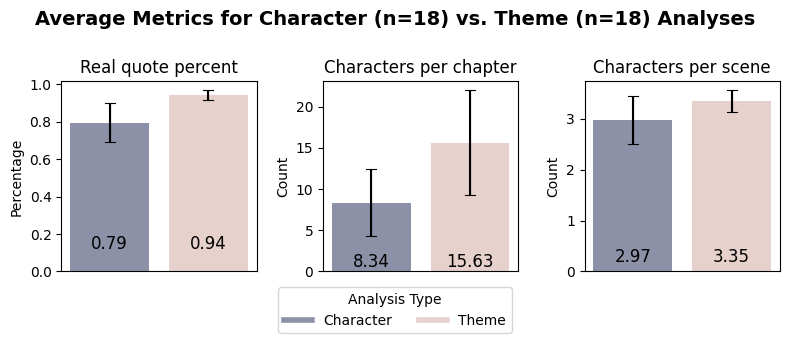

In [61]:
# Plot with adjusted label size and position slightly above y=0
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 3), sharex=False, sharey=False)
axes = axes.flatten()

colors = ['#8d91a8', '#e6d1cc']

# Transpose for easier plotting
# remove 'theme' row
avg_transposed = theme_avg.transpose()
avg_transposed = avg_transposed.drop('llm_generated')
std_transposed = theme_sd.transpose()
std_transposed = std_transposed.drop('llm_generated')

for i, (metric, values) in enumerate(avg_transposed.iterrows()):
    ax = axes[i]
    std_values = std_transposed.loc[metric]
    
    # Plot bars with error bars
    bars = ax.bar(values.index, values.values, color=colors, yerr=std_values.values, capsize=0)
    
    # Adjusted error bar styling: thinner and gray
    for bar, std in zip(bars, std_values.values):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        # Thinner horizontal lines for error bars
        ax.plot([x - 0.05, x + 0.05], [y + std, y + std], color='black', lw=0.8)  # Top horizontal line
        ax.plot([x - 0.05, x + 0.05], [y - std, y - std], color='black', lw=0.8)  # Bottom horizontal line
        # Thinner vertical line for error bars
        ax.vlines(x, y - std, y + std, color='black', lw=0.8)  # Vertical error line (ensure gray is set explicitly)

    # Add y=0 line (dashed gray)
    ax.axhline(0, color='gray', lw=0.5, ls='--')

    ax.set_title(metric.replace('_', ' ').capitalize())
    ax.set_ylabel("Count" if metric != "real_quote_percent" else "Percentage")
    ax.set_xticks([])  # Remove x-axis labels
    ax.set_xlabel("")  # Remove x-axis title
    
    # Add labels slightly above y=0
    for bar in bars:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            0.1,  # Slightly above y=0
            f'{bar.get_height():.2f}',
            ha='center',
            va='bottom',
            fontsize=12  # Slightly larger font size
        )

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)


# add main title
fig.suptitle("Average Metrics for Character (n=18) vs. Theme (n=18) Analyses", fontsize=14, fontweight='bold', x=0.5, y=0.95)

# Add one overall legend with correct color order
fig.legend(labels=['Character', 'Theme'], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.15), title="Analysis Type", handles=[
    plt.Line2D([0], [0], color=colors[0], lw=4),
    plt.Line2D([0], [0], color=colors[1], lw=4),
])
fig.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

#### distributions

In [271]:
df_lines_exploded = df.explode("lines_per_chapter", ignore_index=True)
df_lines_per_chapter = df_lines_exploded[["story", "llm_generated", "themes", "is_play", "story_length", "lines_per_chapter"]]
print(len(df_lines_per_chapter))

df_lines_scene_exploded = df.explode("lines_per_scene", ignore_index=True)
df_lines_per_scene = df_lines_scene_exploded[["story", "llm_generated", "themes", "is_play", "story_length", "lines_per_scene"]]
print(len(df_lines_per_scene))

df_characters_exploded = df.explode("characters_per_chapter", ignore_index=True)
df_characters_per_chapter = df_characters_exploded[["story", "llm_generated", "themes", "is_play", "story_length", "characters_per_chapter"]]
print(len(df_characters_per_chapter))

df_characters_scene_exploded = df.explode("characters_per_scene", ignore_index=True)
df_characters_per_scene = df_characters_scene_exploded[["story", "llm_generated", "themes", "is_play", "story_length", "characters_per_scene"]]
print(len(df_characters_per_scene))

df_locations_exploded = df.explode("locations_per_chapter", ignore_index=True)
df_locations_per_chapter = df_locations_exploded[["story", "llm_generated", "themes", "is_play", "story_length", "locations_per_chapter"]]
print(len(df_locations_per_chapter))

df_scenes_exploded = df.explode("scenes_per_chapter", ignore_index=True)
df_scenes_per_chapter = df_scenes_exploded[["story", "llm_generated", "themes", "is_play", "story_length", "scenes_per_chapter"]]
print(len(df_scenes_per_chapter))

df_real_quotes_exploded = df.explode("real_quote_percent", ignore_index=True)
df_real_quotes = df_real_quotes_exploded[["story", "llm_generated", "themes", "is_play", "story_length", "real_quote_percent"]]
print(len(df_real_quotes))

df_og_scenes_diff_exploded = og_diffs_df.explode("scene_per_chapter_diff", ignore_index=True)
df_og_scenes_per_chapter_diff = df_og_scenes_diff_exploded[["story", "llm_generated", "themes", "scene_per_chapter_diff"]]
print(len(df_og_scenes_per_chapter_diff))

# create map with all df
df_map = {
    "lines_per_chapter": df_lines_per_chapter,
    "lines_per_scene": df_lines_per_scene,
    "characters_per_chapter": df_characters_per_chapter,
    "characters_per_scene": df_characters_per_scene,
    "locations_per_chapter": df_locations_per_chapter,
    "scenes_per_chapter": df_scenes_per_chapter,
    "real_quote_percent": df_real_quotes,
    "og_scene_per_chapter_diff": df_og_scenes_per_chapter_diff
}

1548
9266
1548
9266
1548
1548
72
232


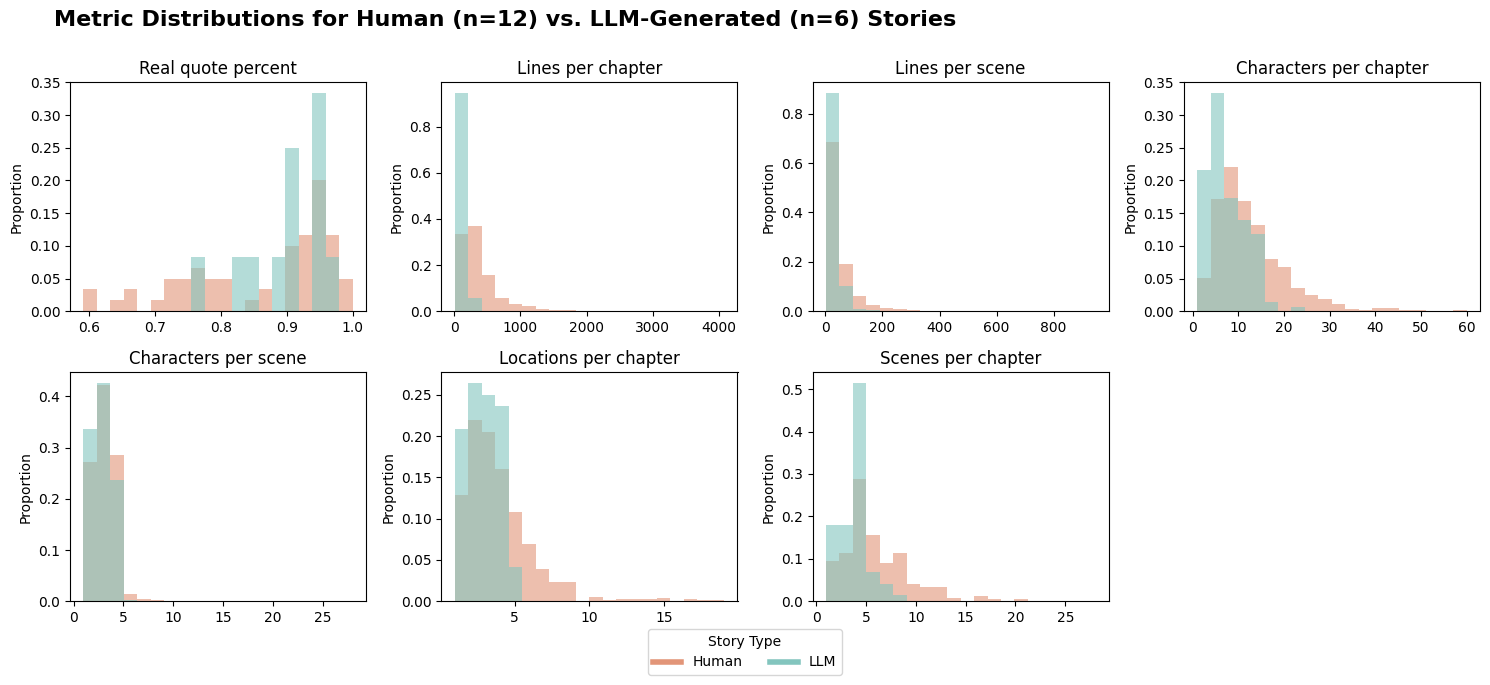

In [125]:
# Define metrics and prepare data
metrics = ['real_quote_percent', 'lines_per_chapter', 'lines_per_scene', 'characters_per_chapter', 'characters_per_scene', 'locations_per_chapter', 'scenes_per_chapter']
num_metrics = len(metrics)
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7), sharex=False, sharey=False)
axes = axes.flatten()

# Colors for the histograms
human_color = '#e29578'
llm_color = '#83c5be'

for i, metric in enumerate(metrics):
    ax = axes[i]

    # Filter data for human and LLM-generated separately
    human_data = df_map[metric][df_map[metric]['llm_generated'] == False]
    llm_data = df_map[metric][df_map[metric]['llm_generated'] == True]

    # Normalize Human data
    human_counts, human_bins = np.histogram(human_data[metric], bins=20)
    human_proportions = human_counts / human_counts.sum()  # Normalize to proportions

    # Normalize LLM data
    llm_counts, llm_bins = np.histogram(llm_data[metric], bins=human_bins)  # Use same bins for comparison
    llm_proportions = llm_counts / llm_counts.sum()  # Normalize to proportions

    # Plot histograms for Human data
    ax.bar(human_bins[:-1], human_proportions, width=np.diff(human_bins), color=human_color, alpha=0.6, label="Human", align='edge')

    # Plot histograms for LLM data
    ax.bar(llm_bins[:-1], llm_proportions, width=np.diff(llm_bins), color=llm_color, alpha=0.6, label="LLM", align='edge')

    # Set titles and labels
    ax.set_title(metric.replace('_', ' ').capitalize())
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")

# Hide any unused subplots
for j in range(num_metrics, len(axes)):
    axes[j].set_visible(False)

# Add main title
fig.suptitle("Metric Distributions for Human (n=12) vs. LLM-Generated (n=6) Stories", fontsize=16, fontweight='bold', y=0.95, x=0.34)

# Add a single legend
fig.legend(labels=['Human', 'LLM'], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.01), title="Story Type",
           handles=[
               plt.Line2D([0], [0], color=human_color, lw=4),
               plt.Line2D([0], [0], color=llm_color, lw=4),
           ])
fig.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.show()


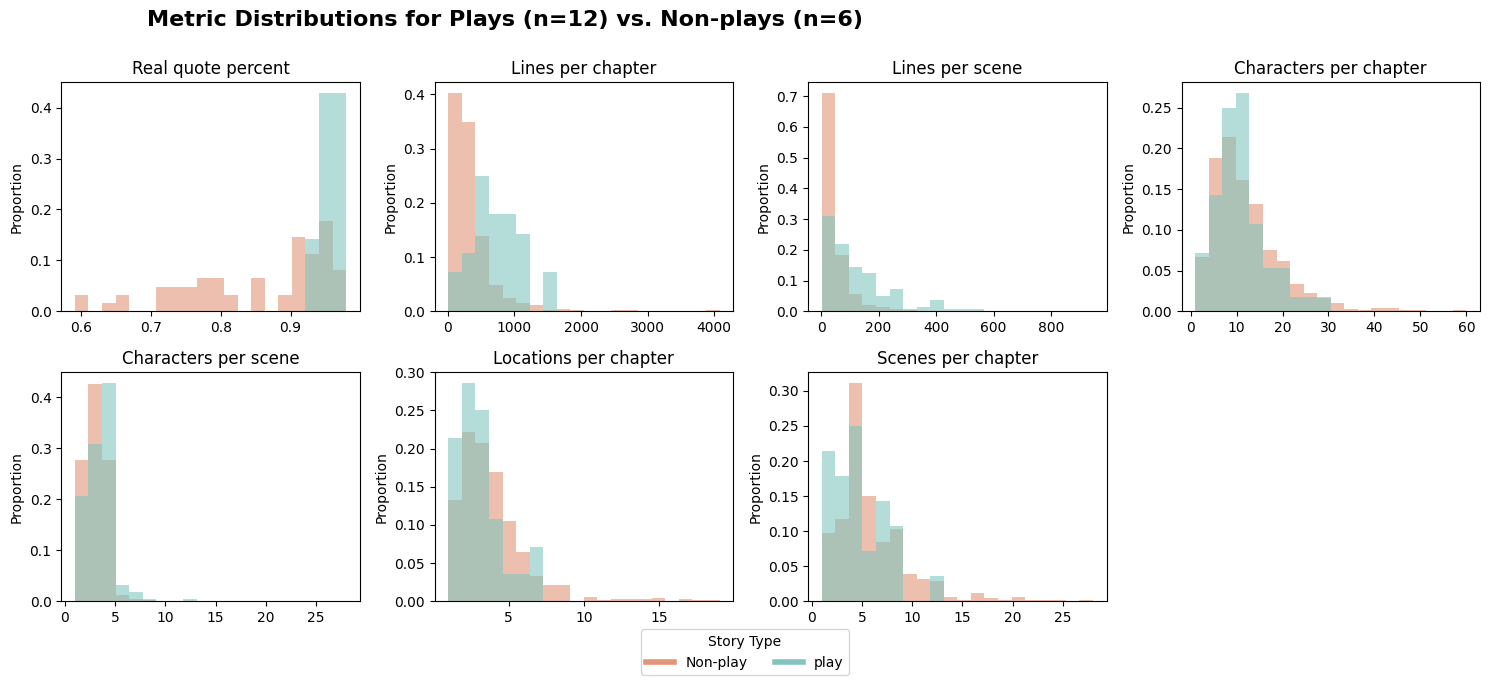

In [272]:
# Define metrics and prepare data
metrics = ['real_quote_percent', 'lines_per_chapter', 'lines_per_scene', 'characters_per_chapter', 'characters_per_scene', 'locations_per_chapter', 'scenes_per_chapter']
num_metrics = len(metrics)
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7), sharex=False, sharey=False)
axes = axes.flatten()

# Colors for the histograms
human_color = '#e29578'
llm_color = '#83c5be'

for i, metric in enumerate(metrics):
    ax = axes[i]

    # Filter data for human and LLM-generated separately
    human_data = df_map[metric][df_map[metric]['is_play'] == False]
    llm_data = df_map[metric][df_map[metric]['is_play'] == True]

    # Normalize Human data
    human_counts, human_bins = np.histogram(human_data[metric], bins=20)
    human_proportions = human_counts / human_counts.sum()  # Normalize to proportions

    # Normalize LLM data
    llm_counts, llm_bins = np.histogram(llm_data[metric], bins=human_bins)  # Use same bins for comparison
    llm_proportions = llm_counts / llm_counts.sum()  # Normalize to proportions

    # Plot histograms for Human data
    ax.bar(human_bins[:-1], human_proportions, width=np.diff(human_bins), color=human_color, alpha=0.6, label="Human", align='edge')

    # Plot histograms for LLM data
    ax.bar(llm_bins[:-1], llm_proportions, width=np.diff(llm_bins), color=llm_color, alpha=0.6, label="LLM", align='edge')

    # Set titles and labels
    ax.set_title(metric.replace('_', ' ').capitalize())
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")

# Hide any unused subplots
for j in range(num_metrics, len(axes)):
    axes[j].set_visible(False)

# Add main title
fig.suptitle("Metric Distributions for Plays (n=12) vs. Non-plays (n=6)", fontsize=16, fontweight='bold', y=0.95, x=0.34)

# Add a single legend
fig.legend(labels=['Non-play', 'play'], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.01), title="Story Type",
           handles=[
               plt.Line2D([0], [0], color=human_color, lw=4),
               plt.Line2D([0], [0], color=llm_color, lw=4),
           ])
fig.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.show()


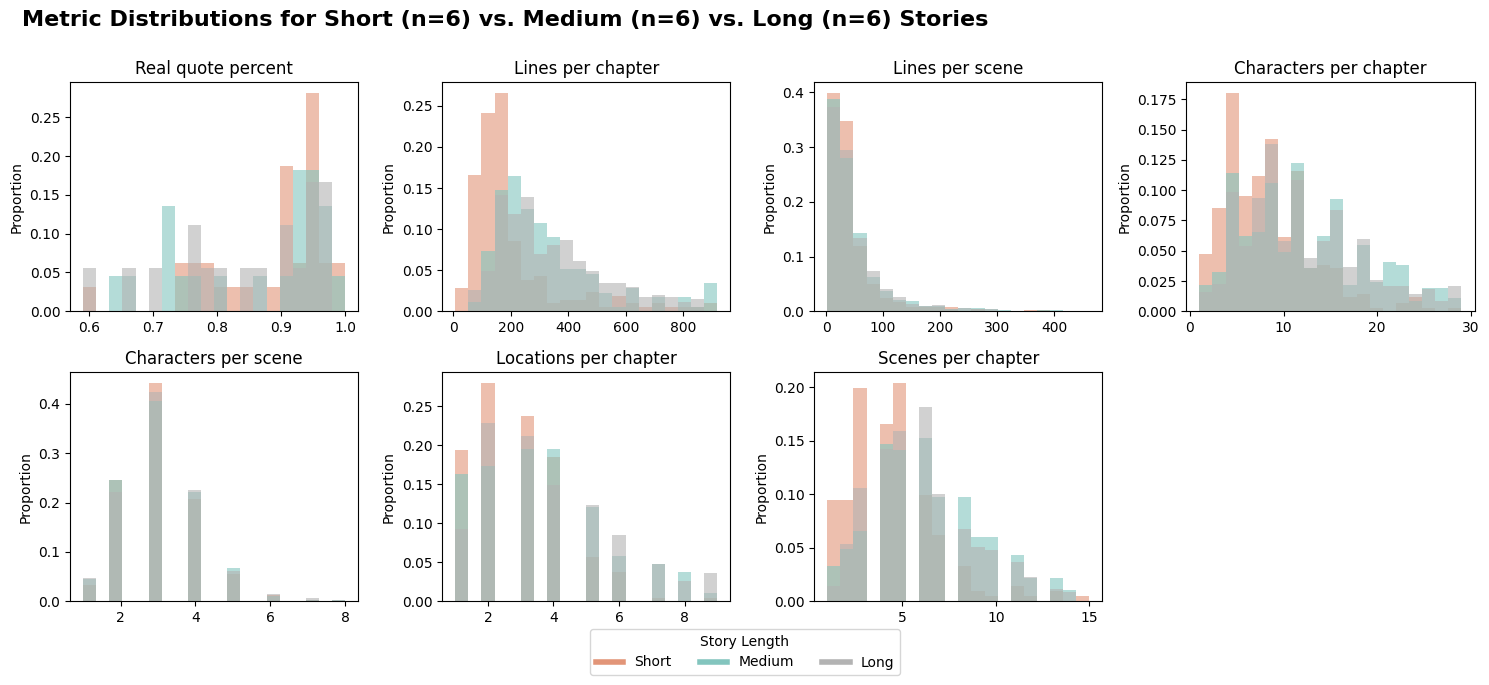

In [124]:
# Define metrics and prepare data
metrics = ['real_quote_percent', 'lines_per_chapter', 'lines_per_scene', 'characters_per_chapter', 'characters_per_scene', 'locations_per_chapter', 'scenes_per_chapter']
num_metrics = len(metrics)
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7), sharex=False, sharey=False)
axes = axes.flatten()

# Colors for the histograms
short_color= '#e29578'
med_color = '#83c5be'
long_color = '#b3b3b3'

for i, metric in enumerate(metrics):
    ax = axes[i]

    # Filter data for short, medium, long stories
    short_data = df_map[metric][df_map[metric]['story_length'] == 'short']
    med_data = df_map[metric][df_map[metric]['story_length'] == 'medium']
    long_data = df_map[metric][df_map[metric]['story_length'] == 'long']

    # Normalize Short data
    short_counts, short_bins = np.histogram(short_data[metric], bins=20)
    short_proportions = short_counts / short_counts.sum()  # Normalize to proportions

    # Normalize Medium data
    med_counts, med_bins = np.histogram(med_data[metric], bins=short_bins)  # Use same bins for comparison
    med_proportions = med_counts / med_counts.sum()  # Normalize to proportions

    # Normalize Long data
    long_counts, long_bins = np.histogram(long_data[metric], bins=short_bins)  # Use same bins for comparison
    long_proportions = long_counts / long_counts.sum()  # Normalize to proportions

    # Plot histograms for Short data
    ax.bar(short_bins[:-1], short_proportions, width=np.diff(short_bins), color=short_color, alpha=0.6, label="Short", align='edge')

    # Plot histograms for Medium data
    ax.bar(med_bins[:-1], med_proportions, width=np.diff(med_bins), color=med_color, alpha=0.6, label="Medium", align='edge')

    # Plot histograms for Long data
    ax.bar(long_bins[:-1], long_proportions, width=np.diff(long_bins), color=long_color, alpha=0.6, label="Long", align='edge')

    # Set titles and labels
    ax.set_title(metric.replace('_', ' ').capitalize())
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")

# Hide any unused subplots
for j in range(num_metrics, len(axes)):
    axes[j].set_visible(False)

# Add main title
fig.suptitle("Metric Distributions for Short (n=6) vs. Medium (n=6) vs. Long (n=6) Stories", fontsize=16, fontweight='bold', y=0.95, x=0.34)

# Add a single legend
fig.legend(labels=['Short', 'Medium', 'Long'], loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.01), title="Story Length",
           handles=[
               plt.Line2D([0], [0], color=short_color, lw=4),
               plt.Line2D([0], [0], color=med_color, lw=4),
               plt.Line2D([0], [0], color=long_color, lw=4),
           ])
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


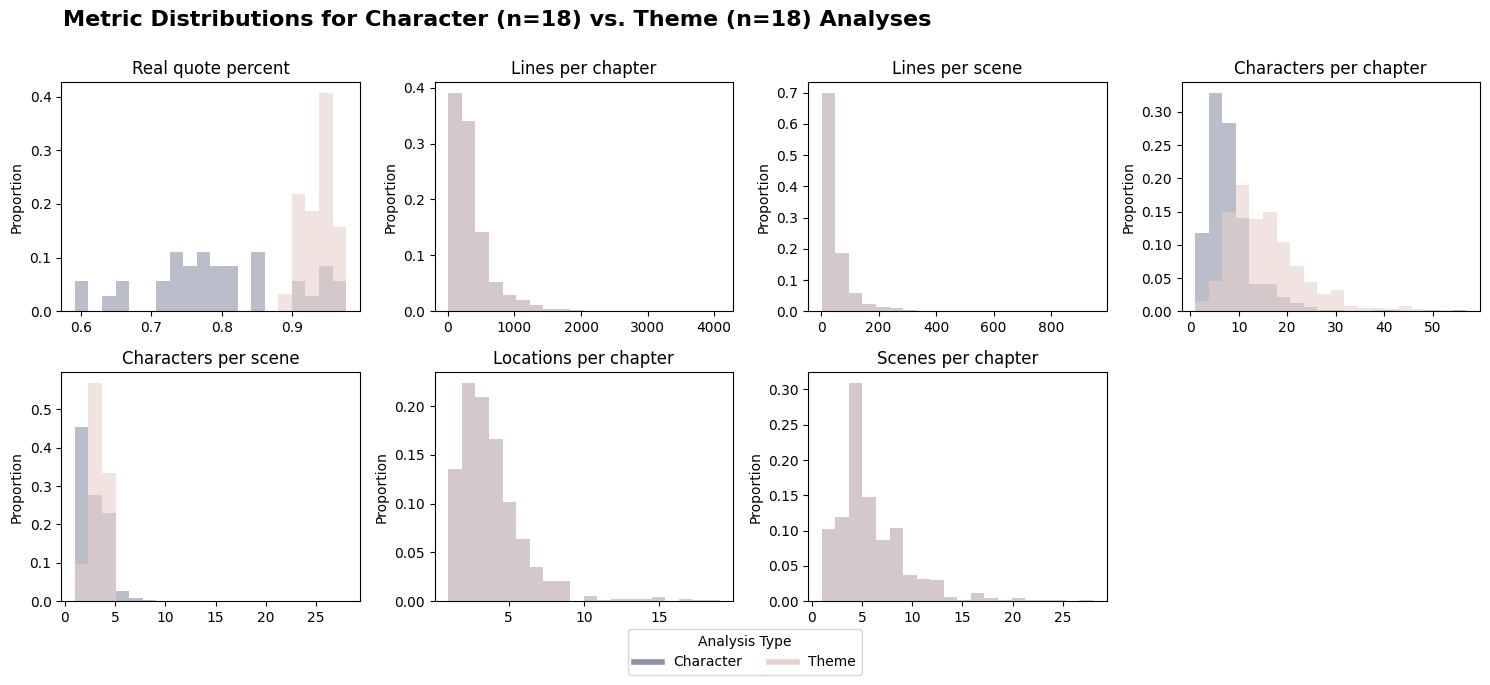

In [69]:
# Define metrics and prepare data
metrics = ['real_quote_percent', 'lines_per_chapter', 'lines_per_scene', 'characters_per_chapter', 'characters_per_scene', 'locations_per_chapter', 'scenes_per_chapter']
num_metrics = len(metrics)
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7), sharex=False, sharey=False)
axes = axes.flatten()

colors = ['#8d91a8', '#e6d1cc']

# Colors for the histograms
character_color = colors[0]
theme_color = colors[1]

for i, metric in enumerate(metrics):
    ax = axes[i]

    # Filter data for character and theme analyses separately
    character_data = df_map[metric][df_map[metric]['themes'] == False]
    theme_data = df_map[metric][df_map[metric]['themes'] == True]

    # Normalize Character data
    character_counts, character_bins = np.histogram(character_data[metric], bins=20)
    character_proportions = character_counts / character_counts.sum()  # Normalize to proportions

    # Normalize Theme data
    theme_counts, theme_bins = np.histogram(theme_data[metric], bins=character_bins)  # Use same bins for comparison
    theme_proportions = theme_counts / theme_counts.sum()  # Normalize to proportions

    # Plot histograms for Human data
    ax.bar(character_bins[:-1], character_proportions, width=np.diff(character_bins), color=character_color, alpha=0.6, label="Human", align='edge')

    # Plot histograms for LLM data
    ax.bar(theme_bins[:-1], theme_proportions, width=np.diff(theme_bins), color=theme_color, alpha=0.6, label="LLM", align='edge')

    # Set titles and labels
    ax.set_title(metric.replace('_', ' ').capitalize())
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")

# Hide any unused subplots
for j in range(num_metrics, len(axes)):
    axes[j].set_visible(False)

# Add main title
fig.suptitle("Metric Distributions for Character (n=18) vs. Theme (n=18) Analyses", fontsize=16, fontweight='bold', y=0.95, x=0.335)

# Add a single legend
fig.legend(labels=['Character', 'Theme'], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.01), title="Analysis Type",
           handles=[
               plt.Line2D([0], [0], color=character_color, lw=4),
               plt.Line2D([0], [0], color=theme_color, lw=4),
           ])
fig.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.show()


In [273]:
df_map["real_quote_percent"]

,story,llm_generated,themes,is_play,story_length,real_quote_percent
0,alice,False,True,False,short,0.899471
1,alice,False,False,False,short,0.806818
2,anne,False,True,False,medium,0.930943
3,anne,False,False,False,medium,0.726837
4,artofwar,False,True,False,medium,0.930693
...,...,...,...,...,...,...
67,war,False,False,False,short,0.734628
68,whispers,True,True,False,short,0.892157
69,whispers,True,False,False,short,0.769697
70,wizard,False,True,False,short,0.929664


In [332]:
# Create histogram just for real quote percent

all_data = df_map["real_quote_percent"]

formatted_data = pd.DataFrame({
   "real_quote_percent": all_data["real_quote_percent"].values,
    "analysis_type": all_data["themes"].replace({True: "Theme", False: "Character"}).values
})

print(len(formatted_data))

custom_colors = ["#E56A8F", "#64B24F"]

chart = alt.Chart(formatted_data).mark_bar(opacity=0.3, binSpacing=0).encode(
    x=alt.X('real_quote_percent:Q', bin=alt.Bin(maxbins=40), title=None, axis=alt.Axis(values=[0.6, 0.8, 1])),
    y=alt.Y('count()', title="Number of Stories").stack(None).axis(grid=False, values=[0, 4, 8, 12]),
    color=alt.Color('analysis_type:N', scale=alt.Scale(domain=['Character', 'Theme'], range=custom_colors), title=None).legend(orient="top-left", offset=10),
).properties(
    width=200,
    height=120
)

# show chart
chart

72


alt.Chart(...)

In [333]:
# Create histogram just for real quote percent

all_data = df_map["real_quote_percent"]

formatted_data2 = pd.DataFrame({
    "real_quote_percent": all_data["real_quote_percent"].values,
    "genre": all_data["is_play"].replace({True: "Play", False: "Non-Play"}).values
})

print(len(formatted_data2))

custom_colors = ["#3B7ACB", "#888888"]

chart2 = alt.Chart(formatted_data2).mark_bar(opacity=0.3, binSpacing=0).encode(
    x=alt.X('real_quote_percent:Q', bin=alt.Bin(maxbins=40), title=None, axis=alt.Axis(values=[0.6, 0.8, 1])),
    y=alt.Y('count()', title=None).stack(None).axis(grid=False, values=[0, 4, 8, 12]),
    color=alt.Color('genre:N', scale=alt.Scale(domain=['Play', 'Non-Play'], range=custom_colors), title=None).legend(orient="top-left", offset=10),
).properties(
    width=200,
    height=120
)

# show chart
chart2

72


alt.Chart(...)

In [330]:
# === Combine side by side with shared x-axis label ===
combined = alt.hconcat(chart, chart2).resolve_scale(
    x='shared',
    color='independent'
).properties(
    spacing=10
)

# Create a dummy chart for the shared x-axis label
x_axis_label = alt.Chart(pd.DataFrame({'x': [0], 'y': [0]})).mark_text(
    text='Percentage of Real Quotes',
    fontSize=11,
    fontWeight='bold',
).encode().properties(
    width=400,
    height=12,
)

# Vertically concatenate combined chart with label
final_chart = alt.vconcat(
    combined,
    x_axis_label
).configure_concat(spacing=5)

final_chart

alt.VConcatChart(...)

In [274]:
# perform t-test for real quote percentage (theme vs. non-theme)
theme_real_quote = df_map["real_quote_percent"][df_map["real_quote_percent"]["themes"] == True]["real_quote_percent"]
non_theme_real_quote = df_map["real_quote_percent"][df_map["real_quote_percent"]["themes"] == False]["real_quote_percent"]

print("len theme:", len(theme_real_quote))
print("len non_theme:", len(non_theme_real_quote))

t_stat, p_val = ttest_ind(theme_real_quote, non_theme_real_quote)
print("t-statistic:", t_stat)
print("p-value:", p_val)

len theme: 36
len non_theme: 36
t-statistic: 8.25094929923709
p-value: 6.301645124371846e-12


In [275]:
# perform t-test for real quote percentage (play vs. non-play)
play_real_quote_percent = df_map["real_quote_percent"][df_map["real_quote_percent"]["is_play"] == True]["real_quote_percent"]
non_play_real_quote_percent = df_map["real_quote_percent"][df_map["real_quote_percent"]["is_play"] == False]["real_quote_percent"]

print("len play:", len(play_real_quote_percent))
print("len non_play:", len(non_play_real_quote_percent))

t_stat, p_val = ttest_ind(play_real_quote_percent, non_play_real_quote_percent)
print("t-statistic:", t_stat)
print("p-value:", p_val)

len play: 10
len non_play: 62
t-statistic: 3.3938152812027527
p-value: 0.0011382011913497743


In [279]:
# perform t-test for lines per scene (play vs. non-play)
play_lines_per_scene = average_df["lines_per_scene"][average_df["is_play"] == True]
non_play_lines_per_scene = average_df["lines_per_scene"][average_df["is_play"] == False]

print("len play:", len(play_lines_per_scene))
print("len non_play:", len(non_play_lines_per_scene))

t_stat, p_val = ttest_ind(play_lines_per_scene, non_play_lines_per_scene)
print("t-statistic:", t_stat)
print("p-value:", p_val)

len play: 10
len non_play: 62
t-statistic: 9.780427914515974
p-value: 9.974387450432455e-15


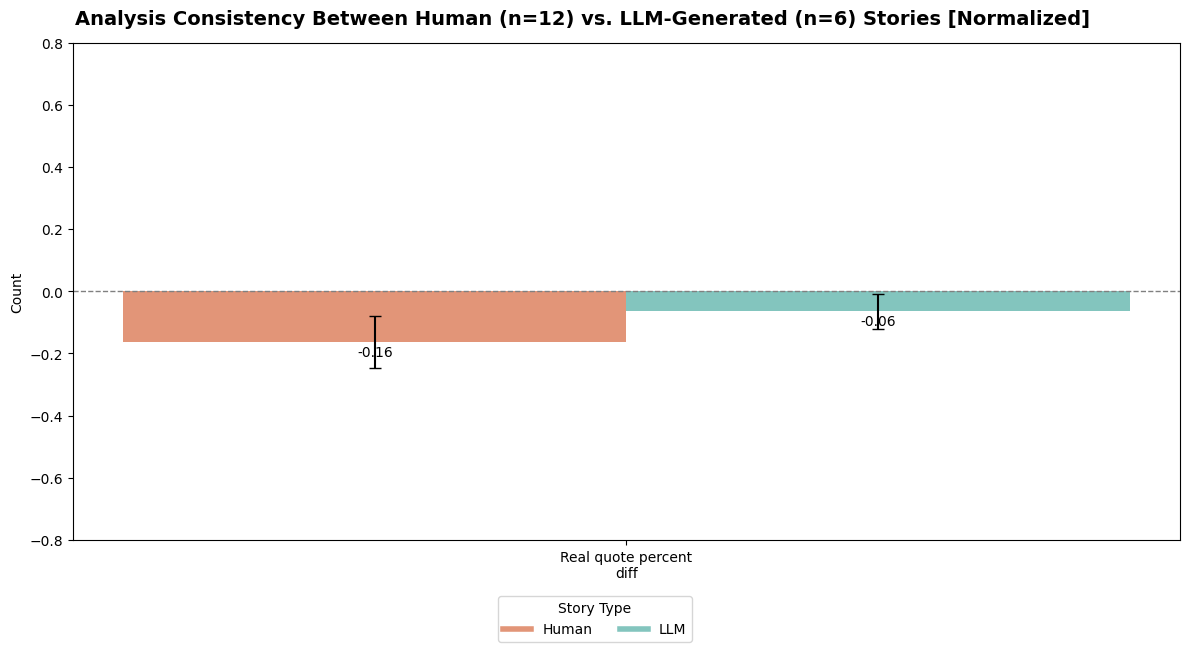

In [71]:
colors = ['#e29578', '#83c5be']
labels = ['Human', 'LLM']

# Transpose for easier plotting
avg_transposed = llm_diff_avg.transpose()
std_transposed = llm_diff_sd.transpose()
# remove 'diff_num_chapters' row
# avg_transposed = avg_transposed.drop('diff_num_chapters')
# std_transposed = std_transposed.drop('diff_num_chapters')

# Metrics on the x-axis
metrics = avg_transposed.index.str.replace('_', ' ').str.capitalize()

# Function to wrap labels after `n` words
def wrap_label(label, n=3):
    words = label.split()
    wrapped = '\n'.join([' '.join(words[i:i + n]) for i in range(0, len(words), n)])
    return wrapped

# Apply wrapping
wrapped_labels = [wrap_label(label, n=3) for label in metrics]

x_positions = np.arange(len(metrics))  # X positions for metrics
bar_width = 0.4

# Prepare a figure
fig, ax = plt.subplots(figsize=(12, 6))

# Add a horizontal line at y=0
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

# Calculate data range to expand y-axis
all_values = avg_transposed.values.flatten()
y_min, y_max = np.min(all_values), np.max(all_values)
y_range = y_max - y_min
# ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
ax.set_ylim(-0.8, 0.8)

# Plot bars for Character and Theme
for i, label in enumerate(labels):
    values = avg_transposed.iloc[:, i]
    std_values = std_transposed.iloc[:, i]
    
    bars = ax.bar(
        x_positions + i * bar_width - bar_width / 2,
        values,
        width=bar_width,
        color=colors[i],
        label=label,
        capsize=4,
        yerr=std_values.values,
    )

    for bar in bars:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() - 0.01 if bar.get_height() < 0 else bar.get_height() + 0.01,
            f'{bar.get_height():.2f}',
            ha='center',
            va='top' if bar.get_height() < 0 else 'bottom',
            fontsize=10
        )

# Customize the x-axis
ax.set_xticks(x_positions)
ax.set_xticklabels(wrapped_labels, rotation=0, ha='center')  # Apply wrapped labels
ax.set_ylabel("Count")
ax.set_title("Analysis Consistency Between Human (n=12) vs. LLM-Generated (n=6) Stories [Normalized]", fontsize=14, fontweight='bold', x=0.46, y=1.02)

# Add a legend
fig.legend(labels=labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.09), title="Story Type",
           handles=[
               plt.Line2D([0], [0], color=colors[0], lw=4),
               plt.Line2D([0], [0], color=colors[1], lw=4),
           ])

fig.tight_layout()
plt.show()

In [73]:
# # Define metrics and prepare data
# metrics = ['diff_num_scenes', 'diff_num_locations', 'scene_per_chapter_diff', 'locations_per_chapter_diff', 'scene_lines_diff']
# num_metrics = len(metrics)
# nrows, ncols = 2, 3
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 9), sharex=False, sharey=False)
# axes = axes.flatten()

# # Colors for the histograms
# human_color = '#e29578'
# llm_color = '#83c5be'

# for i, metric in enumerate(metrics):
#     ax = axes[i]

#     # Filter data for human and LLM-generated separately
#     human_data = df_map[metric][df_map[metric]['llm_generated'] == False]
#     llm_data = df_map[metric][df_map[metric]['llm_generated'] == True]

#     # Normalize Human data
#     human_counts, human_bins = np.histogram(human_data[metric], bins=20)
#     human_proportions = human_counts / human_counts.sum()  # Normalize to proportions

#     # Normalize LLM data
#     llm_counts, llm_bins = np.histogram(llm_data[metric], bins=human_bins)  # Use same bins for comparison
#     llm_proportions = llm_counts / llm_counts.sum()  # Normalize to proportions

#     # Plot histograms for Human data
#     ax.bar(human_bins[:-1], human_proportions, width=np.diff(human_bins), color=human_color, alpha=0.6, label="Human", align='edge')

#     # Plot histograms for LLM data
#     ax.bar(llm_bins[:-1], llm_proportions, width=np.diff(llm_bins), color=llm_color, alpha=0.6, label="LLM", align='edge')

#     # Set titles and labels
#     ax.set_title(metric.replace('_', ' ').capitalize())
#     ax.set_ylabel("Proportion")
#     ax.set_xlabel("")

# # Hide any unused subplots
# for j in range(num_metrics, len(axes)):
#     axes[j].set_visible(False)

# # Add main title
# fig.suptitle("Analysis Distribution Consistency for Human (n=12) vs. LLM-Generated (n=6) Stories", fontsize=16, fontweight='bold', y=0.95, x=0.4)

# # Add a single legend
# fig.legend(labels=['Human', 'LLM'], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.03), title="Story Type",
#            handles=[
#                plt.Line2D([0], [0], color=human_color, lw=4),
#                plt.Line2D([0], [0], color=llm_color, lw=4),
#            ])
# fig.tight_layout(rect=[0, 0.05, 1, 0.95])

# plt.show()

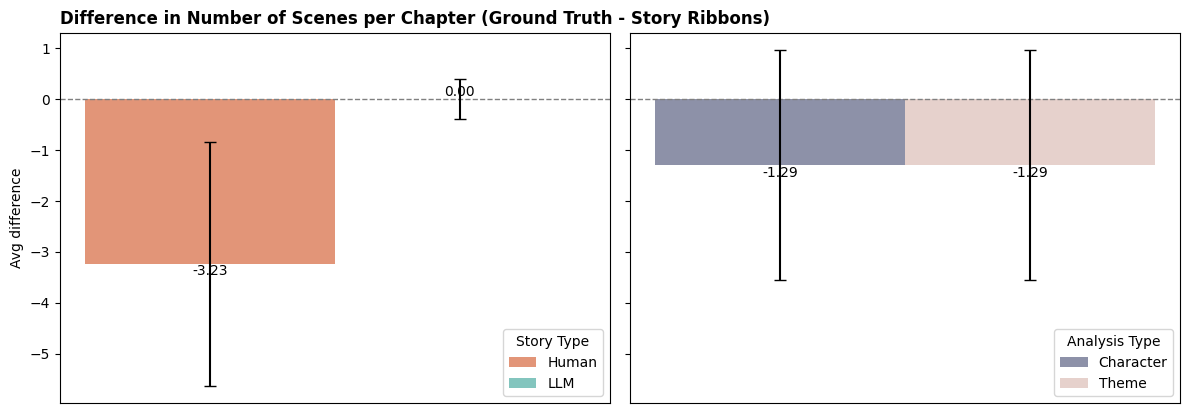

In [74]:
colors = ['#e29578', '#83c5be']
labels = ['Human', 'LLM']

# Transpose for easier plotting
avg_transposed = og_diff_avg_llm.transpose()
std_transposed = og_diff_sd_llm.transpose()
# drop 'themes' column
avg_transposed = avg_transposed.drop('themes')
std_transposed = std_transposed.drop('themes')

avg2_transposed = og_diff_avg_themes.transpose()
std2_transposed = og_diff_sd_themes.transpose()
# drop 'llm_generated' column
avg2_transposed = avg2_transposed.drop('llm_generated')
std2_transposed = std2_transposed.drop('llm_generated')

# Metrics on the x-axis
metrics = avg_transposed.index.str.replace('_', ' ').str.capitalize()

# Function to wrap labels after `n` words
def wrap_label(label, n=3):
    words = label.split()
    wrapped = '\n'.join([' '.join(words[i:i + n]) for i in range(0, len(words), n)])
    return wrapped

# Apply wrapping
wrapped_labels = [wrap_label(label, n=3) for label in metrics]

# Additional colors and labels for the second subplot
colors2 = ['#8d91a8', '#e6d1cc']  # Different color scheme
labels2 = ['Character', 'Theme']

# Prepare a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)  # sharey=True to align the y-axes

# Plot the first subplot
ax1.axhline(0, color='gray', linestyle='--', linewidth=1)
x_positions = np.arange(len(metrics))
bar_width = 0.4

for i, label in enumerate(labels):
    values = avg_transposed.iloc[:, i]
    std_values = std_transposed.iloc[:, i]
    
    bars = ax1.bar(
        x_positions + i * bar_width - bar_width / 2,
        values,
        width=bar_width,
        color=colors[i],
        label=label,
        capsize=4,
        yerr=std_values.values,
    )

    for bar in bars:
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() - 0.01 if bar.get_height() < 0 else bar.get_height() + 0.01,
            f'{bar.get_height():.2f}',
            ha='center',
            va='top' if bar.get_height() < 0 else 'bottom',
            fontsize=10
        )

# ax1.set_xticks(x_positions)
# ax1.set_xticklabels(wrapped_labels, rotation=0, ha='center')
ax1.set_xticks([])
ax1.set_ylabel("Avg difference")
# ax1.set_title("Difference in Number of Scenes (LLM vs Human)", fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', title="Story Type")

# Plot the second subplot
ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
x_positions2 = np.arange(len(avg2_transposed.index))  # Adjust x positions for the second dataset
wrapped_labels2 = [wrap_label(label, n=3) for label in avg2_transposed.index.str.replace('_', ' ').str.capitalize()]

for i, label in enumerate(labels2):
    values = avg2_transposed.iloc[:, i]
    std_values = std2_transposed.iloc[:, i]
    
    bars = ax2.bar(
        x_positions2 + i * bar_width - bar_width / 2,
        values,
        width=bar_width,
        color=colors2[i],
        label=label,
        capsize=4,
        yerr=std_values.values,
    )

    for bar in bars:
        ax2.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() - 0.01 if bar.get_height() < 0 else bar.get_height() + 0.01,
            f'{bar.get_height():.2f}',
            ha='center',
            va='top' if bar.get_height() < 0 else 'bottom',
            fontsize=10
        )

# ax2.set_xticks(x_positions2)
# ax2.set_xticklabels(wrapped_labels2, rotation=0, ha='center')
ax2.set_xticks([])
# ax2.set_title("Difference in Number of Scenes (Themes)", fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', title="Analysis Type")

fig.tight_layout()
# set main title
fig.suptitle("Difference in Number of Scenes per Chapter (Ground Truth - Story Ribbons)", fontsize=12, fontweight='bold', y=1.02, x=0.35)
plt.show()


In [76]:
# # Define metrics and prepare data
# metrics = ['og_scene_per_chapter_diff', 'og_scene_per_chapter_diff']
# og_metric_names = ['scene_per_chapter_diff', 'scene_per_chapter_diff']
# num_metrics = len(metrics)
# nrows, ncols = 1, 2
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7), sharex=False, sharey=True)
# axes = axes.flatten()

# # Colors for the histograms
# human_color = '#e29578'
# llm_color = '#83c5be'
# character_color = '#8d91a8'
# theme_color = '#e6d1cc'

# for i, metric in enumerate(metrics):
#     ax = axes[i]

#     metric_name = og_metric_names[i]

#     # Filter data for human and LLM-generated separately
#     if i % 2 == 0:
#         human_data = df_map[metric][df_map[metric]['llm_generated'] == False]
#         llm_data = df_map[metric][df_map[metric]['llm_generated'] == True]
#     else:
#         human_data = df_map[metric][df_map[metric]['themes'] == False]
#         llm_data = df_map[metric][df_map[metric]['themes'] == True]

#     # Normalize Human data
#     human_counts, human_bins = np.histogram(human_data[metric_name], bins=20)
#     human_proportions = human_counts / human_counts.sum()  # Normalize to proportions

#     # Normalize LLM data
#     llm_counts, llm_bins = np.histogram(llm_data[metric_name], bins=human_bins)  # Use same bins for comparison
#     llm_proportions = llm_counts / llm_counts.sum()  # Normalize to proportions

#     # Plot histograms for Human data
#     ax.bar(human_bins[:-1], human_proportions, width=np.diff(human_bins), color=human_color if i % 2 == 0 else character_color, 
#            alpha=0.6, label="Human" if i % 2 == 0 else "Character", align='edge')

#     # Plot histograms for LLM data
#     ax.bar(llm_bins[:-1], llm_proportions, width=np.diff(llm_bins), color=llm_color if i % 2 == 0 else theme_color, 
#            alpha=0.6, label="LLM" if i % 2 == 0 else "Theme", align='edge')

#     # Set titles and labels
#     # ax.set_title(metric.replace('_', ' ').capitalize())
#     ax.set_ylabel("Proportion" if i == 0 else "")
#     ax.set_xlabel("Number of Scenes")

#     ax.legend(labels=['Human', 'LLM'] if i % 2 == 0 else ['Character', 'Theme'], loc='upper left', title="Story Type" if i % 2 == 0 else "Analysis Type")

# # Hide any unused subplots
# for j in range(num_metrics, len(axes)):
#     axes[j].set_visible(False)

# # Add main title
# fig.suptitle("Distribution of Difference in Number of Scenes per Chapter (Ground Truth - Story Ribbons)", fontsize=16, fontweight='bold', y=0.95, x=0.43)

# # Add a single legend
# fig.tight_layout(rect=[0, 0.05, 1, 0.95])

# plt.show()

## checking quotes

In [373]:
def check_quotes(story, story_type):
    suffix = "-new-themes.json" if story_type == "themes" else "-new.json"
    with open(data_folder + story + suffix, 'r') as file:
        data = json.load(file)

    quote_count = 0
    wrong_quote_count = 0
    scenes = data["scenes"]
    for scene in scenes:
        scene_name = scene["title"]
        scene_chapter = scene["chapter"]
        scene_text = scene["text"]
        scene_text = scene_text.replace("\n", " ").replace("_", "").lower()
        scene_text = re.sub(r'[^\w\s]', '', scene_text) # remove punctuation
 
        # get all characters in scene
        characters = scene["characters"]
        for character in characters:
            # check quote
            if "No quote available" not in character["quote"]:
                og_quote = character["quote"]
                quote = og_quote.replace("_", "").lower()
                quote = re.sub(r'[^\w\s]', '', quote) # remove punctuation
                quote_count += 1
                
                # try to find in original text
                if quote not in scene_text:
                    # try searching for broken up quote
                    # quote_parts = re.split(r"[,.?!;]", quote)  # Split by comma, period, question mark, and exclamation mark
                    # quote_parts = [part.strip() for part in quote_parts]
                    # found = True
                    # min_index = 0
                    # for part in quote_parts:
                    #     find_index = scene_text.find(part, min_index)
                    #     if find_index == -1:
                    #         found = False
                    #         break
                    #     min_index = find_index + len(part)

                    # if not found:
                    wrong_quote_count += 1
                    print("Quote not found")
                    # print("part:", part)
                    print(quote)
                    print(og_quote)
                    print(scene_text)
                    print(f"Chapter: {scene_chapter}, Scene: {scene_name}, Character: {character['name']}")
                    print()

    if wrong_quote_count > 0:
        print(story, story_type)
        print(f"Wrong quotes: {wrong_quote_count}/{quote_count}")
        print("--------------------")

In [374]:
len(df["story"].unique()), df["story"].unique()

(30,
 array(['alice', 'anne', 'artofwar', 'bookstore', 'color', 'donquixote',
        'emma', 'faust', 'frankenstein', 'gatsby', 'genji', 'greatexp',
        'hamlet', 'iliad', 'marrow', 'mendips', 'metamorphosis', 'odyssey',
        'pride', 'redchamber', 'romeo', 'starlight', 'threads', 'time',
        'trial', 'ulysses', 'victoria', 'war', 'whispers', 'wizard'],
       dtype=object))

In [375]:
for i, story in enumerate(df["story"].unique()):
    # if i != 17:
    #     continue
    check_quotes(story, "characters")
    check_quotes(story, "themes")

# story = "anne"
# check_quotes(story, "characters")
# check_quotes(story, "themes")